# Analyzing a single NuSTAR observation

## Learning Goals

By the end of this tutorial, you will:

- Understand how to search for and download observational data for NuSTAR and other missions.
- Re-run the data reduction pipeline to produce clean event files.
- Use `heasoftpy` to extract data products and start the analysis.


## Introduction
In this tutorial, we will go through the steps of analyzing a NuSTAR observation of the active galactic nuclei (AGN) in the center of `SWIFT J2127.4+5654` using `heasoftpy`.

Most of the X-ray mission data hosted at the HEASARC is analyzed using the legacy [HEASoft](https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/) package. In this tutorial, we walk through the steps needed to extract the spectral and timing products of AGN using NuSTAR data.

We will specifically focus on analyzing one observation (`60001110002`) of the Narrow Line Seyfert 1 galaxy `SWIFT J2127.4+5654`.

### Inputs

- The name of the source of interest.
- The ObsID of the single observation we wish to use.

### Outputs

- Light curves for the source and background.
- Spectra for the source and background.
- Visualizations of the light curve and spectra.
- Fitted spectral model parameters.

### Runtime

As of 3rd February 2026, this notebook takes ~25m to run to completion on Fornax using the 'High-Energy Astrophysics' image and the 'small' server with 8GB RAM/ 2 cores.


## Imports

We assume `heasoftpy` and HEASoft are present on your system; installing the [heasoft conda package](https://heasarc.gsfc.nasa.gov/docs/software/conda.html) may be the easiest option.
The following command will set up a new Conda environment with the latest version of HEASoft installed (you may substitute 'conda' with 'mamba', or whichever skew of Conda you use):

```
conda create -n hea_env heasoft -c https://heasarc.gsfc.nasa.gov/FTP/software/conda
```

You may also install HEASoft from source following the [standard installation instructions](https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/#install).

As this guide uses `heasoftpy`, be sure to set the 'PYTHON' environment variable before building HEASoft from source; otherwise heasoftpy may not function correctly.
We note that the analyses performed in this notebook can also be run using the equivalent 'traditional' HEASoft commands in the command line.

We also use `xspec` to load the spectra data products.

Finding and downloading data is down using the [heasarc](https://astroquery.readthedocs.io/en/latest/heasarc/heasarc.html) module in `astroquery`. Also, if downloading data from Amazon Web Services, install `boto3` too.

We also use `astropy` to handle coordinates, units, and the reading of FITS files, and `matplotlib` for plotting.

**Fornax & SciServer**: When running this on [Fornax](https://docs.fornax.sciencecloud.nasa.gov/) or [SciServer](https://heasarc.gsfc.nasa.gov/docs/sciserver/), make sure to select the heasoft kernel from the drop-down list in the top-right of this notebook.

In [1]:
import contextlib
import os

import heasoftpy as hsp
import matplotlib.pyplot as plt
import xspec as xs
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astroquery.heasarc import Heasarc
from matplotlib.ticker import FuncFormatter

%matplotlib inline

## Global Setup

### Functions

### Constants

In [2]:
# Defining some global input variables
# The name of demonstration source
SOURCE = "SWIFT J2127.4+5654"

# The ObsID of the observation we wish to use
OBS_ID = "60001110002"

### Configuration

In [3]:
# ------------- Configure global package settings --------------
# Raise Python exceptions if a heasoftpy task fails
# TODO Remove once this becomes a default in heasoftpy
hsp.Config.allow_failure = False
# --------------------------------------------------------------

# --------------- Configure matplotlib settings ----------------
# Modify the style of all plots produced in this notebook
plt.rcParams.update(
    {
        "font.size": 14,
        "lines.markersize": 5.0,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.top": True,
        "ytick.right": True,
        "xtick.major.size": 9.0,
        "ytick.major.size": 9.0,
    }
)
# --------------------------------------------------------------

# -------------- Set paths and create directories --------------
if os.path.exists("../../../_data"):
    ROOT_DATA_DIR = "../../../_data/NuSTAR/"
else:
    ROOT_DATA_DIR = "NuSTAR/"

ROOT_DATA_DIR = os.path.abspath(ROOT_DATA_DIR)

# Make sure the download directory exists.
os.makedirs(ROOT_DATA_DIR, exist_ok=True)

# Setup path and directory into which we save output files from this example.
OUT_PATH = os.path.abspath("NuSTAR_output")
os.makedirs(OUT_PATH, exist_ok=True)
# --------------------------------------------------------------

***

## 1. Considering the steps needed to extract the data products

The steps we will follow are:
- Find and download the data.
- Re-run the NuSTAR pipeline to produce clean events files using `nupipeline`.
- Extract the data products using `nuproducts`.

## 2. Find and download Data

HEASARC data holdings can be accessed in many different ways. The `astroquery` and `pyvo` modules provide a variety of ways to access our data when using Python.

- `astroquery` - provides high-level access with convenience functions for general usage.
- `pyvo` - uses Virtual Observatory protocols to offer more powerful low-level access that supports [complex queries](https://nasa-navo.github.io/navo-workshop/content/reference_notebooks/catalog_queries.html).

***

In our case, we are looking for data for a specific object in the sky. The steps are:
1. Find the name of the NuSTAR master catalog (if not already known).
2. Query the catalog for observations of the source of interest.
3. Locate the corresponding data.
4. Download the data of interest.

### Searching for the NuSTAR observation summary table

We can use the `astroquery.heasarc` module to search for the NuSTAR 'master' catalog by
passing 'nustar' as a keyword and setting `master=True`:

In [4]:
# Find the name of the NuSTAR master catalog
catalog_name = Heasarc.list_catalogs(master=True, keywords="nustar")[0]["name"]
catalog_name

np.str_('numaster')

### Querying the table for NuSTAR observations of our source

Now that we know the name of the table that contains a summary of all NuSTAR
observations, we can search it for observations targeted within a
particular radius of our source's coordinates.

We can quickly find the likely coordinates of our source from its name by using
the Astropy `SkyCoord` class's `from_name` method, which will use a name resolver
to look up the information:

In [5]:
# Find the coordinates of the source
position = SkyCoord.from_name(SOURCE)
position

<SkyCoord (ICRS): (ra, dec) in deg
    (321.93914228, 56.9430322)>

Now we perform our query using the default search radius assigned to the NuSTAR
observation summary table:

In [6]:
# Query the archive for a list of observations
observations = Heasarc.query_region(position, catalog=catalog_name)
observations

name,ra,dec,time,obsid,status,exposure_a,observation_mode,obs_type,processing_date,public_date,issue_flag,__row
,deg,deg,d,,,s,,,d,d,,
object,float64,float64,float64,object,object,float64,object,object,float64,int32,int16,object
SwiftJ2127d4p5654,321.8865,56.8893,56235.7230,60001110002,archived,49200,SCIENCE,AGN,59170.4000,56694,0,5778
SWIFT_J2127d4p5654,321.9575,56.9122,58482.3272,60402008010,archived,74246,SCIENCE,N04,59061.8000,58859,0,5783
SwiftJ2127d4p5654,321.9125,56.9214,56236.7542,60001110003,archived,28764,SCIENCE,AGN,59170.4000,56694,0,5784
SwiftJ2127d4p5654,321.9235,56.9256,56237.7473,60001110005,archived,74578,SCIENCE,AGN,59170.4000,56694,1,5785
SwiftJ2127d4p5654,321.9412,56.9294,56239.7022,60001110007,archived,42106,SCIENCE,AGN,59170.3000,56694,0,5786
SWIFT_J2127d4p5654,321.8852,56.9316,58375.6952,60402008008,archived,72875,SCIENCE,N04,59065.6000,58859,0,5787
SWIFT_J2127d4p5654,321.9207,56.9606,58304.6848,60402008002,archived,71255,SCIENCE,N04,59073.1000,58859,1,5788
SWIFT_J2127d4p5654,321.8877,56.9639,58329.8550,60402008006,archived,72130,SCIENCE,N04,59072.5000,58859,0,5789


```{note}
The default search radius will vary from catalog to catalog, but can be retrieved
using the `Heasarc.get_default_radius(...)` method and passing the catalog name as
an argument.

We could also specify a custom search radius by passing an Astropy `Quantity` object
for the `radius` argument of `Heasarc.query_region`.
```

### Filtering for our pre-chosen ObsID

To make sure this notebook runs in a reasonable amount of time, we're only using a single NuSTAR observation, the ObsID
of which we defined in the [Global Setup: Constants](#constants) section near the top of this notebook.

As such, we have to filter the table of observations we just retrieved to only include the one we want to use:

In [7]:
# Filter the observations table to the one ObsID we will use
selected_obs = observations[observations["obsid"] == OBS_ID]
selected_obs

name,ra,dec,time,obsid,status,exposure_a,observation_mode,obs_type,processing_date,public_date,issue_flag,__row
,deg,deg,d,,,s,,,d,d,,
object,float64,float64,float64,object,object,float64,object,object,float64,int32,int16,object
SwiftJ2127d4p5654,321.8865,56.8893,56235.7230,60001110002,archived,49200,SCIENCE,AGN,59170.4000,56694,0,5778


### Locating and downloading the data
To actually retrieve the data, we can use the `locate_data()` method of Astroquery's `Heasarc` to fetch download links:

In [8]:
# Find where the data are stored
links = Heasarc.locate_data(selected_obs)
links

ID,access_url,sciserver,aws,content_length,error_message
,,,,byte,
object,object,str38,str51,int64,object
ivo://nasa.heasarc/numaster?5778,https://heasarc.gsfc.nasa.gov/FTP/nustar/data/obs/00/6//60001110002/,/FTP/nustar/data/obs/00/6/60001110002/,s3://nasa-heasarc/nustar/data/obs/00/6/60001110002/,527203978,


You may notice that there are several links for our observation. This is because HEASARC stores data both on its own
servers and in an open Amazon Web Services (AWS) S3 bucket.

Passing the previously retrieved data links to the `download_data()` method
of `Heasarc` (the last time we use Astroquery in this demonstration) we can acquire the
observation data files and store them in our data directory:

In [9]:
Heasarc.download_data(links, host="aws", location=ROOT_DATA_DIR)

INFO: Downloading data AWS S3 ... [astroquery.heasarc.core]
INFO: Enabling anonymous cloud data access ... [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/nustar/data/obs/00/6/60001110002/ [astroquery.heasarc.core]


INFO: downloading s3://nasa-heasarc/nustar/data/obs/00/6/60001110002/ [astroquery.heasarc.core]


## 3. Data Reduction

Next, we use `nupipeline` ([see the pipeline description here](https://heasarc.gsfc.nasa.gov/lheasoft/ftools/caldb/help/nupipeline.html)) to process the raw observation into a set of science-ready data products.

As we show in the {doc}`HEASoftPy Getting Started <../../useful_high_energy_tools/heasoftpy/heasoftpy-getting-started>` tutorial, we can either call `hsp.nupipeline` or create an instance of `hsp.HSPTask`. Here, we use the former

Note that to run `nupipeline`, only three parameters are needed: `indir`, `outdir` and `steminput`. By default, calling the task will also query for other parameters. We can instruct the task to use default values by setting `noprompt=True`.

Also, because `nupipeline` takes some time to run (up to tens of minutes), and we wish to track its progress, we make sure the task output prints to screen by setting `verbose=True`.

```{caution}
If, in your version of this notebook, you are processing _many_ NuSTAR observations, be aware that printing the output may result in some amount of slowdown.
```

For the purposes of this tutorial, we will focus only on the `FMPA` instrument (NuSTAR has two nominally identical telescopes and instruments: `FPMA` and `FPMB`).

This call to `nupipeline` will process the raw data and store the output in the `NUSTAR_output/60001110002/event_cl` directory - the `NUSTAR_output` part of this path is set by the `OUT_PATH` constant defined in the [Global Setup: Constants](#constants) section:

In [10]:
# Ensure that the ObsID-specific output directory exists
os.makedirs(os.path.join(OUT_PATH, f"{OBS_ID}"), exist_ok=True)

# This 'context' (i.e. the with statement) will move us into the output directory
#  for the pipeline run. Also if the run fails, it will ensure we return to our
#  original working directory.
with contextlib.chdir(os.path.join(OUT_PATH, f"{OBS_ID}")):
    nupipe_out = hsp.nupipeline(
        indir=os.path.join(ROOT_DATA_DIR, f"{OBS_ID}"),
        outdir="event_cl",
        steminputs=f"nu{OBS_ID}",
        instrument="FPMA",
        clobber="yes",
        noprompt=True,
        verbose=True,
    )


                 Running NuSTAR pipeline
 Task: nupipeline Version: 0.4.12 Release Date: 2023-11-16
nupipeline_0.4.12: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - TELDEF 2012-11-04 17:21:07 "-" retrieve+ clobber=yes
CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuA20100101v002.teldef 0
nupipeline_0.4.12: Info: CallQuzcif: Running quzcif NuSTAR FPM - - ALIGNMENT 2012-11-04 17:21:07 "type.eq.systems" retrieve+ clobber=yes
CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuCalign20120101v001.fits 1
------------------------------------------------------------
               Setting Optical Axis Direction
------------------------------------------------------------
nupipeline_0.4.12: Info: 'pntra' and/or 'pntdec' input parameter set to POINT
nupipeline_0.4.12: Info: getting default S/C direction
nupipeline_0.4.12: Info: Optical Axis   RA : 3.2188650000000E+02(deg)
nupipeline_0.4.12: Info: Optical Axis  DEC : 5.6889300000000E+01(deg)
nupipeline_0.4.12: Info: 

nupipeline_0.4.12: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - TELDEF 2012-11-04 17:21:07 "-" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuA20100101v002.teldef 0
nupipeline_0.4.12: Info: CallQuzcif: Running quzcif NuSTAR FPM - - ALIGNMENT 2012-11-04 17:21:07 "type.eq.systems" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuCalign20120101v001.fits 1
------------------------------------------------------------
               Setting Optical Axis Direction
------------------------------------------------------------
nupipeline_0.4.12: Info: 'pntra' and/or 'pntdec' input parameter set to POINT
nupipeline_0.4.12: Info: getting default S/C direction
nupipeline_0.4.12: Info: Optical Axis   RA : 3.2188650000000E+02(deg)
nupipeline_0.4.12: Info: Optical Axis  DEC : 5.6889300000000E+01(deg)
nupipeline_0.4.12: Info: Running 'numetrology' 
nupipeline_0.4.12: Command: numetrology clobber=yes alignfile=nuCalign20120101v001.fits metrologyfile=/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002_met.fits.gz outpsdfilecor=./event_cl/nu60001110002_psdcorr.fits psdcal=yes mastaspectfile=./event_cl/nu60001110002_mast.fits history=yes chatter=3 inpsdfilecor= outpsdfile=./event_cl/nu60001110002_psd.fits metflag=yes metgridfile=CALDB


---------------------------------------------------------------------
 		Running 'numetrology_0.1.9'
---------------------------------------------------------------------
		 Input Parameters List: 
Name of the input Metrology File                      :'/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002_met.fits.gz'
Name of the input Metrology Grid File                 :'CALDB'
Name of the output Position Sensing Detector File     :'./event_cl/nu60001110002_psd.fits'
Name of the output corrected Position Sensing Detector File :'./event_cl/nu60001110002_psdcorr.fits'
Apply PSD linearization to the corrected Position Sensing Detector File : yes
Name of the input Alignment File                           :'nuCalign20120101v001.fits'
Name of the output Mast Aspect Solution File               :'./event_cl/nu60001110002_mast.fits'
---------------------------------------------------------------------
numetrology_0.1.9: Warning: /home/jovyan/project/_data/NuSTAR/60001110002/hk/nu600

---------------------------------------------------------------------
 		Running 'nuattcorr_0.1.2'
---------------------------------------------------------------------
		 Input Parameters List: 
Name of the input Attitude file                       :'/home/jovyan/project/_data/NuSTAR/60001110002/auxil/nu60001110002_att.fits.gz'
Name of the output Corrected Attitude file            :'./event_cl/nu60001110002_att.fits'
Name of the input CHUs Quaternion Offset FITS file    :'CALDB'
---------------------------------------------------------------------
nuattcorr_0.1.2: Info: Creating '3271_tmp_nuattcorr/3271in_nu60001110002_att.fits.gz' symbolic link to input Attitude file.
nuattcorr_0.1.2: Info: Processing https://heasarc.gsfc.nasa.gov/FTP/caldb/data/nustar/fpm/bcf/instrument/nuCchuoffset20100101v001.fits file.
nuattcorr_0.1.2: Info: executing 'ftcopy infile='3271_tmp_nuattcorr/3271in_nu60001110002_att.fits.gz[col @3271_tmp_nuattcorr/3271in.col]' outfile=3271_tmp_nuattcorr/3271out_nu60001

nuattcorr_0.1.2: Info: './event_cl/nu60001110002_att.fits' file successfully written.
---------------------------------------------------------------------
nuattcorr_0.1.2: Exit with success.
---------------------------------------------------------------------
nupipeline_0.4.12: Info: 'nuattcorr' exit with success. './event_cl/nu60001110002_att.fits' corrected attitude file created.
nupipeline_0.4.12: Info: Copying OBEB HK File '/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002_obeb.hk.gz' in './event_cl/nu60001110002_obeb.hk'
nupipeline_0.4.12: Info: Copying Level 1 Event File '/home/jovyan/project/_data/NuSTAR/60001110002/event_uf/nu60001110002A_uf.evt.gz' in './event_cl/nu60001110002A_uf.evt.gz'
nupipeline_0.4.12: Info: the file './event_cl/nu60001110002A_uf.evt.gz' is compressed
nupipeline_0.4.12: Info: Unzip the file to allow FTOOLS processing



nupipeline_0.4.12: Stage  I: Calibrating './event_cl/nu60001110002A_uf.evt'

nupipeline_0.4.12: Info: Running 'nuflagbad' 
nupipeline_0.4.12: Command: nuflagbad outbpfile=./event_cl/nu60001110002A_bp.fits infile=./event_cl/nu60001110002A_uf.evt chatter=3 history=yes bpfile=CALDB dispixfile=/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_dspx.fits.gz userbpfile=NONE clobber=yes outfile=./event_cl/nu60001110002A_uf.2030tmp


---------------------------------------------------------------------
 		Running 'nuflagbad_0.1.8'
---------------------------------------------------------------------
		 Input Parameters List: 
Name of the input Event file                          :'./event_cl/nu60001110002A_uf.evt'
Name of the output Event file                         :'./event_cl/nu60001110002A_uf.2030tmp'
Name of the input on-board disabled pixel file        :'/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_dspx.fits.gz'
Name of the input on-ground bad pixel file            :'CALDB'
Name of the input user bad pixel file                 :'NONE'
Name of the output Bad Pixel file                     :'./event_cl/nu60001110002A_bp.fits'
---------------------------------------------------------------------
nuflagbad_0.1.8: Info: Processing 'https://heasarc.gsfc.nasa.gov/FTP/caldb/data/nustar/fpm/bcf/badpix/nuAbadpix20100101v003.fits' file for on-ground bad pixel data of detector DET0.
nuflagbad_0.1.8: I

nupipeline_0.4.12: Info: 'nuflagbad' exit with success. './event_cl/nu60001110002A_uf.evt' updated
nupipeline_0.4.12: Info: Running 'nuhotpix' 
nupipeline_0.4.12: Command: nuhotpix cellsize=5 outfile=./event_cl/nu60001110002A_uf.2030tmp history=yes iterate=yes chatter=3 infile=./event_cl/nu60001110002A_uf.evt clobber=yes logpos=-6.0 bthresh=6 binsize=600.0 impfac=1.0 outhpfile=./event_cl/nu60001110002A_hp.fits cleanflick=yes


---------------------------------------------------------------------
 		Running 'nuhotpix_0.1.7'
---------------------------------------------------------------------
		 Input Parameters List: 
Name of the input Event file                          :'./event_cl/nu60001110002A_uf.evt'
Name of the output Event file                         :'./event_cl/nu60001110002A_uf.2030tmp'
Name of the output Hot Pixel file                     :'./event_cl/nu60001110002A_hp.fits'
Bin size (seconds) for count image generation         :'600.000000'
Search and flag flickering pixels?                      : yes
Iterate the search                                      : yes
---------------------------------------------------------------------
nuhotpix_0.1.7: Info: Processing './event_cl/nu60001110002A_uf.evt' file.
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89745601.000000 - 89746201.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: 

 rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=3 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=29 rawy= 2 det_id=1 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89751601.000000 - 89752201.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89752201.000000 - 89752801.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=15 rawy=30 det_id=3 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx= 5 rawy=11 det_id=0 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89752801.000000 - 89753401.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: 

h TIME included in [89765401.000000 - 89766001.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=30 rawy=26 det_id=1 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=16 rawy= 5 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=30 rawy=15 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=31 rawy=18 det_id=2 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89766001.000000 - 89766601.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=12 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=15 rawy=30 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89766601.000000 - 89767201.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Found Hot 

 rawx=31 rawy=19 det_id=3 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx= 9 rawy=23 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89773201.000000 - 89773801.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=3 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx= 8 rawy=13 det_id=2 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89773801.000000 - 89774401.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=3 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89774401.000000 - 89775001.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_

o: Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=31 rawy=18 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=14 rawy= 0 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89780401.000000 - 89781001.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89781001.000000 - 89781601.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=15 rawy=30 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89781601.000000 - 89782201.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nu

.1.7: Info: Creating count maps for events with TIME included in [89787001.000000 - 89787601.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx= 9 rawy= 4 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=16 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=27 rawy=26 det_id=3 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=18 rawy= 6 det_id=1 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=31 rawy= 3 det_id=3 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=31 rawy=19 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89787601.000000 - 89788201.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=3 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=23 rawy= 2 det_id=0 
nuhotpix_0.1.7: Info: C

n [89793001.000000 - 89793601.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=3 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx= 7 rawy=30 det_id=1 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=31 rawy=18 det_id=2 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89793601.000000 - 89794201.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=18 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89794201.000000 - 89794801.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89794801.000000 - 89795401.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhot


nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=3 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx= 6 rawy= 0 det_id=3 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=19 rawy=27 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89801401.000000 - 89802001.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=15 rawy=30 det_id=3 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89802001.000000 - 89802601.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=30 rawy=26 det_id=1 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=3 
nuhotpix_0.1.7: Info: Crea

l in rawx=12 rawy=31 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89808001.000000 - 89808601.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx= 1 rawy= 8 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89808601.000000 - 89809201.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=22 rawy=25 det_id=0 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89809201.000000 - 89809801.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=14 rawy=16 det_id=0 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy= 7 det_id=3 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=3 
nuhotpix_0.1.7: Info: Iter

det_id=1 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=19 rawy=23 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89815201.000000 - 89815801.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=18 det_id=0 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=3 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=12 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=18 rawy=31 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89815801.000000 - 89816401.000000]
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89816401.000000 - 89817001.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=30 rawy= 9 det_id=0 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=12 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in

xel in rawx=20 rawy=27 det_id=0 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=31 rawy=18 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=30 rawy=18 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89823001.000000 - 89823601.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=15 rawy=30 det_id=3 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=3 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=27 rawy= 0 det_id=1 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=13 rawy=25 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=30 rawy=14 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89823601.000000 - 89824201.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx= 9 rawy= 6 det_id=1 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot P

: Iter 1 Found Hot Pixel in rawx=27 rawy=16 det_id=0 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=27 rawy= 3 det_id=1 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=31 rawy=18 det_id=2 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89829001.000000 - 89829601.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=31 rawy=18 det_id=2 
nuhotpix_0.1.7: Info: Iter 1 Found Hot Pixel in rawx=19 rawy=30 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89829601.000000 - 89830201.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=18 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=31 rawy=19 det_id=2 
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=15 rawy=30 det_id=3 
nuhotpix_0.1.7: Info: Creating count maps for events with TIME included in [89830201.000000 - 89830801.000000]
nuhotpix_0.1.7: Info: Found Hot Pixel in rawx=27 

nupipeline_0.4.12: Info: 'nuhotpix' exit with success. './event_cl/nu60001110002A_uf.evt' updated
nupipeline_0.4.12: Info: Running 'nucalcpha' 
nupipeline_0.4.12: Command: nucalcpha evtthr=55 phaparfile=CALDB clobber=yes gradefile=CALDB history=yes infile=./event_cl/nu60001110002A_uf.evt chatter=3 timerise=0.0016 offsetfile=CALDB outfile=./event_cl/nu60001110002A_uf.2030tmp cleancols=yes


---------------------------------------------------------------------
 		Running 'nucalcpha_0.2.2'
---------------------------------------------------------------------
		 Input Parameters List: 
Name of the input Event file                          :'./event_cl/nu60001110002A_uf.evt'
Name of the output Event file                         :'./event_cl/nu60001110002A_uf.2030tmp'
Name of the input Offset file                         :'CALDB'
Name of the input Grade file                          :'CALDB'
Name of the input PHAPAR file                         :'CALDB'
Delete temporary columns                              : yes
---------------------------------------------------------------------
nucalcpha_0.2.2: Info: Processing 'https://heasarc.gsfc.nasa.gov/FTP/caldb/data/nustar/fpm/bcf/grade/nuCgrade20100101v002.fits' file.
nucalcpha_0.2.2: Info: Processing 'https://heasarc.gsfc.nasa.gov/FTP/caldb/data/nustar/fpm/bcf/cap_offset/nuAoffset20100101v001.fits' file.
nucalcpha_0.2.2: Info: Proc

ha_0.2.2: Info: Total events with grade 27                 131    0.0174%
nucalcpha_0.2.2: Info: Total events with grade 28                  81    0.0108%
nucalcpha_0.2.2: Info: Total events with grade 29                  71    0.0095%
nucalcpha_0.2.2: Info: Total events with grade 30                  82    0.0109%
nucalcpha_0.2.2: Info: Total events with grade 31                 340    0.0453%
nucalcpha_0.2.2: Info: Total events with grade 32              528379   70.3832%
nucalcpha_0.2.2: Info: './event_cl/nu60001110002A_uf.2030tmp' file successfully written.
---------------------------------------------------------------------
nucalcpha_0.2.2: Exit with success.
---------------------------------------------------------------------
nupipeline_0.4.12: Info: 'nucalcpha' exit with success. './event_cl/nu60001110002A_uf.evt' updated
nupipeline_0.4.12: Info: Running 'nucalcpi' 
nupipeline_0.4.12: Command: nucalcpi temperature=5 outfile=./event_cl/nu60001110002A_uf.2030tmp clobber=yes hkfi

---------------------------------------------------------------------
 		Running 'nucalcpi_0.2.2'
---------------------------------------------------------------------
		 Input Parameters List: 
Name of the input Event file                          :'./event_cl/nu60001110002A_uf.evt'
Name of the input HK Header file                      :'/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_fpm.hk.gz'
Name of the input GAIN file                           :'CALDB'
Name of the output Event file                         :'./event_cl/nu60001110002A_uf.2030tmp'
---------------------------------------------------------------------
nucalcpi_0.2.2: Info: Processing './event_cl/nu60001110002A_uf.evt' file.
nucalcpi_0.2.2: Info: Processing /home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_fpm.hk.gz file.
nucalcpi_0.2.2: Info: Processing 'https://heasarc.gsfc.nasa.gov/FTP/caldb/data/nustar/fpm/bcf/gain/nuAgain20100101v011.fits' file for gain data of detector DET0.
nucalcpi

---------------------------------------------------------------------
 		Running 'nuflagevt_0.1.4'
---------------------------------------------------------------------
		 Input Parameters List: 
Name of the input Event file                          :'./event_cl/nu60001110002A_uf.evt'
Name of the output Event file                         :'./event_cl/nu60001110002A_uf.2030tmp'
---------------------------------------------------------------------
nuflagevt_0.1.4: Info: Processing 'https://heasarc.gsfc.nasa.gov/FTP/caldb/data/nustar/fpm/bcf/instrument/nuAdepthcut20100101v004.fits' file for depth cut data of detector DET0_SINGLE.
nuflagevt_0.1.4: Info: Processing 'https://heasarc.gsfc.nasa.gov/FTP/caldb/data/nustar/fpm/bcf/instrument/nuAdepthcut20100101v004.fits' file for depth cut data of detector DET1_SINGLE.
nuflagevt_0.1.4: Info: Processing 'https://heasarc.gsfc.nasa.gov/FTP/caldb/data/nustar/fpm/bcf/instrument/nuAdepthcut20100101v004.fits' file for depth cut data of detector DET2_SIN

nupipeline_0.4.12: Info: 'nuflagevt' exit with success. './event_cl/nu60001110002A_uf.evt' updated
nupipeline_0.4.12: Info: Running 'nucoord' 
nupipeline_0.4.12: Command: nucoord randomizecoordinator=yes pntra=3.2188650000000E+02 det1reffile=./event_cl/nu60001110002A_det1.fits optaxisfile=./event_cl/nu60001110002A_oa.fits det1xref=350 initseed=no pntdec=5.6889300000000E+01 aberration=no attfile=./event_cl/nu60001110002_att.fits outfile=./event_cl/nu60001110002A_uf.2030tmp seedcoordinator=-1956 det1yref=350 history=yes chatter=3 infile=./event_cl/nu60001110002A_uf.evt mastaspectfile=./event_cl/nu60001110002_mast.fits pixposfile=CALDB clobber=yes follow_sun=yes alignfile=nuCalign20120101v001.fits timemargin=32.0 teldef=nuA20100101v002.teldef attinterpol=LINEAR
--------------------------------------------------------------
             Running ' nucoord version 0.1.8 '
--------------------------------------------------------------
nucoord_0.1.8: Info: Name of the Input Event File  './even

nucoord_0.1.8: Info: Copying input file to '3630_tmp_nucoord/nu60001110002A_uf.2030tmp'
nucoord_0.1.8: Info: Computing DET1 and DET2 coordinates
nucoord_0.1.8: Info: Running 'nucalcpos' 
nucoord_0.1.8: Command: nucalcpos history=yes outfile=3630_tmp_nucoord/nu60001110002A_uf.3630tmp clobber=yes mastaspectfile=./event_cl/nu60001110002_mast.fits initseed=no pixposfile=CALDB alignfile=nuCalign20120101v001.fits infile=3630_tmp_nucoord/nu60001110002A_uf.2030tmp chatter=3 saveraw2coord=no


---------------------------------------------------------------------
 		Running 'nucalcpos_0.2.4'
---------------------------------------------------------------------
		 Input Parameters List: 
Name of the input Event file                          :'3630_tmp_nucoord/nu60001110002A_uf.2030tmp'
Name of the output Event file                         :'3630_tmp_nucoord/nu60001110002A_uf.3630tmp'
Name of the input pixel location file                 :'CALDB'
Name of the input Alignment File                           :'nuCalign20120101v001.fits'
Name of the input Mast Aspect Solution File               :'./event_cl/nu60001110002_mast.fits'
---------------------------------------------------------------------
nucalcpos_0.2.4: Info: Processing nuCalign20120101v001.fits file.
nucalcpos_0.2.4: Info: Processing '3630_tmp_nucoord/nu60001110002A_uf.2030tmp' file.
nucalcpos_0.2.4: Info: Processing 'https://heasarc.gsfc.nasa.gov/FTP/caldb/data/nustar/fpm/bcf/pixpos/nuApixpos20100101v007.fits' file f

nucoord_0.1.8: Info: 'nucalcpos' exit with success. DET1 and DET2 coordinates computed.


nucoord_0.1.8: Info: Computing X and Y coordinates
nucoord_0.1.8: Info: Running 'coordinator' 
nucoord_0.1.8: Command: coordinator aberration=no attfile=3630_tmp_nucoord/nu60001110002_att.fits randomize=yes skyynull=-1 follow_sun=yes history=yes timecol=TIME ra=3.2188650000000E+02 dec=5.6889300000000E+01 teldef=3630_tmp_nucoord/nuA20100101v002.teldef skyxnull=-1 eventext=EVENTS chatter=3 interpolation=LINEAR timemargin=32.0 seed=-1956 eventfile=3630_tmp_nucoord/nu60001110002A_uf.2030tmp


using LINEAR interpolation for aspecting
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
1% done
1% done
1% done
1% done
1% done
1% done
1% done
1% done
1% done
1% done
1% done
1% done
1% done
2% done
2% done
2% done
2% done
2% done
2% done
2% done
2% done
2% done
2% done
2% done
2% done
2% done
2% done
3% done
3% done
3% done
3% done
3% done
3% done
3% done
3% done
3% done
3% done
3% done
3% done
3% done
4% done
4% done
4% done
4% done
4% done
4% done
4% done
4% done
4% done
4% done
4% done
4% done
4% done
4% done
5% done
5% done
5% done
5% done
5% done
5% done
5% done
5% done
5% done
5% done
5% done
5% done
5% done
6% done
6% done
6% done
6% done
6% done
6% done
6% done
6% done
6% done
6% done
6% done
6% done
6% done
6% done
7% done
7% done
7% done
7% done
7% done
7% done
7% done
7% done
7% done
7% done
7% done
7% done
7% done
8% done
8% done
8% done
8% done
8% done
8% done
8% done
8% done
8% done
8% done
8% done
8% done
8% done

done
34% done
34% done
34% done
34% done
35% done
35% done
35% done
35% done
35% done
35% done
35% done
35% done
35% done
35% done
35% done
35% done
35% done
35% done
36% done
36% done
36% done
36% done
36% done
36% done
36% done
36% done
36% done
36% done
36% done
36% done
36% done
37% done
37% done
37% done
37% done
37% done
37% done
37% done
37% done
37% done
37% done
37% done
37% done
37% done
37% done
38% done
38% done
38% done
38% done
38% done
38% done
38% done
38% done
38% done
38% done
38% done
38% done
38% done
39% done
39% done
39% done
39% done
39% done
39% done
39% done
39% done
39% done
39% done
39% done
39% done
39% done
39% done
40% done
40% done
40% done
40% done
40% done
40% done
40% done
40% done
40% done
40% done
40% done
40% done
40% done
41% done
41% done
41% done
41% done
41% done
41% done
41% done
41% done
41% done
41% done
41% done
41% done
41% done
41% done
42% done
42% done
42% done
42% done
42% done
42% done
42% done
42% done
42% done
42% done
42% done
42% d

one
68% done
68% done
68% done
68% done
68% done
68% done
68% done
69% done
69% done
69% done
69% done
69% done
69% done
69% done
69% done
69% done
69% done
69% done
69% done
69% done
70% done
70% done
70% done
70% done
70% done
70% done
70% done
70% done
70% done
70% done
70% done
70% done
70% done
70% done
71% done
71% done
71% done
71% done
71% done
71% done
71% done
71% done
71% done
71% done
71% done
71% done
71% done
72% done
72% done
72% done
72% done
72% done
72% done
72% done
72% done
72% done
72% done
72% done
72% done
72% done
72% done
73% done
73% done
73% done
73% done
73% done
73% done
73% done
73% done
73% done
73% done
73% done
73% done
73% done
74% done
74% done
74% done
74% done
74% done
74% done
74% done
74% done
74% done
74% done
74% done
74% done
74% done
74% done
75% done
75% done
75% done
75% done
75% done
75% done
75% done
75% done
75% done
75% done
75% done
75% done
75% done
76% done
76% done
76% done
76% done
76% done
76% done
76% done
76% done
76% done
76% do

nucoord_0.1.8: Info: 'coordinator' exit with success. X and Y coordinates computed.
nucoord_0.1.8: Info: Moving temporary file '3630_tmp_nucoord/nu60001110002A_uf.2030tmp' to output file './event_cl/nu60001110002A_uf.2030tmp'
nucoord_0.1.8: Info: Output Event File './event_cl/nu60001110002A_uf.2030tmp' successfully written.
nucoord_0.1.8: Info: Creating Optical Axis File
nucoord_0.1.8: Info: Running 'nuskypos' 
nucoord_0.1.8: Command: nuskypos det1yref=350 alignfile=nuCalign20120101v001.fits teldef=nuA20100101v002.teldef pntdec=5.6889300000000E+01 initseed=no det1reffile=./event_cl/nu60001110002A_det1.fits aberration=no attfile=./event_cl/nu60001110002_att.fits history=yes det1xref=350 pntra=3.2188650000000E+02 chatter=3 instrument=FPMA optaxisfile=./event_cl/nu60001110002A_oa.fits clobber=yes mastaspectfile=./event_cl/nu60001110002_mast.fits


---------------------------------------------------------------------
 		Running 'nuskypos_0.1.3'
---------------------------------------------------------------------
nuskypos_0.1.3: Info: Processing nuCalign20120101v001.fits file.
nuskypos_0.1.3: Info: Processing ./event_cl/nu60001110002_att.fits file.
nuskypos_0.1.3: Info: './event_cl/nu60001110002A_oa.fits' file successfully written.
nuskypos_0.1.3: Info: './event_cl/nu60001110002A_det1.fits' file successfully written.
nucoord_0.1.8: Info: 'nuskypos' exit with success. './event_cl/nu60001110002A_oa.fits' Optical Axis File created.
----------------------------------------------------------
nucoord_0.1.8: Exit with success 
------------------------------------------------------------
nupipeline_0.4.12: Info: 'nucoord' exit with success. './event_cl/nu60001110002A_uf.evt' updated



nupipeline_0.4.12: Stage  I: './event_cl/nu60001110002A_uf.evt' calibrated.


nupipeline_0.4.12: Stage II: Screening './event_cl/nu60001110002A_uf.evt'

nupipeline_0.4.12: Info: Running 'nucalcsaa' 
nupipeline_0.4.12: Command: nucalcsaa hkfile=/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_fpm.hk.gz evtfile=./event_cl/nu60001110002A_uf.evt tentacleregcut=yes history=yes evtexpr="STATUS==b000000000x0xx000&&SHIELD==0&&GRADE.LE.26" chatter=3 tentaclerms=4.5 outfile=./event_cl/nu60001110002A_fpm.hk sourcethr=4.0 eliminatesource=yes orbitfile=/home/jovyan/project/_data/NuSTAR/60001110002/auxil/nu60001110002_orb.fits.gz tentaclesanitychecks=yes tentacle=no saamode=NONE saacalc=3 saaparfile=CALDB optimizedrms=4.5 optimizedsanitychecks=yes clobber=yes


---------------------------------------------------------------------
 		Running 'nucalcsaa_0.1.7'
---------------------------------------------------------------------
		 Input Parameters List: 
Name of the input Housekeeping file                      :'/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_fpm.hk.gz'
Name of the input Orbit file                             :'/home/jovyan/project/_data/NuSTAR/60001110002/auxil/nu60001110002_orb.fits.gz'
Name of the input Event file                             :'./event_cl/nu60001110002A_uf.evt'
Name of the output Housekeeping file                     :'./event_cl/nu60001110002A_fpm.hk'
SAA calculation algorithm ('1'=v1; '2'=v2; '3'=v3)       :'3'
SAA removal function mode                                :'NONE'
New Optimized SAA filtering RMS threshold                :'4.500000'
New Tentacle SAA filtering RMS threshold                 :'4.500000'
Eliminate the source for events rate estimation          : yes
Sigma upper limit 

CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuCpreconf20100101v001.fits 1
nufilter_0.1.7: Info: Using FITS  PRECONF File from CALDB:
nufilter_0.1.7: Info: 'nuCpreconf20100101v001.fits' extension '1'
nufilter_0.1.7: Command: prefilter timeadj=DEFAULT columns="TIME POSITION VELOCITY QUATERNION PNTUNIT POLAR SAT_ALT SAT_LAT SAT_LON RA DEC ROLL ELV BR_EARTH FOV_FLAG SUNSHINE SUN_ANGLE MOON_ANGLE RAM_ANGLE ANG_DIST COR_ASCA COR_SAX MCILWAIN_L SAA SAA_TIME " ranom=3.2188650000000E+02 leapname=/opt/envs/heasoft/heasoft/refdata/leapsec.fits orbmode=TLE_TEXT2 history=yes attname=3725_tmp_nufilter/nu60001110002_att.fits outname=3725_tmp_nufilter/nu60001110002A.attorb clobber=yes orbname=3725_tmp_nufilter/NUSTAR_TLE_ARCHIVE.txt.2020322 rigname=/opt/envs/heasoft/heasoft/refdata/rigidity.data origin=NASA/GSFC decnom=5.6889300000000E+01 start=89745601. missepoch=2010-01-01T00:00:00.000 interval=1.0 end=89834701. chatter=3 alignfile=3725_tmp_nufilter/nuA20100101v002.teldef


monitor: 2010-01-01T00:00:00.000 => mjd[utc]=55197.000000000000 str=10/01/01 00:00:00.000000
status: no special handling for TELESCOP 'NuSTAR'
status: derived time offset -1.000000 from leap seconds
nufilter_0.1.7: Info: 'prefilter' exit with success. './event_cl/nu60001110002A.attorb' created
nufilter_0.1.7: Info: Create an ASCII Makefilter configuration file
nufilter_0.1.7: Info: CallQuzcif: Running quzcif NuSTAR FPM - - MKFCONF NOW NOW "-" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuCmkfconf20100101v005.fits 1
nufilter_0.1.7: Info: Using FITS Makefilter Configuration File from CALDB:
nufilter_0.1.7: Info: 'nuCmkfconf20100101v005.fits' extension '1'
nufilter_0.1.7: Info: Created './event_cl/nu60001110002A_mkf.conf' file
nufilter_0.1.7: Info: Makefilter output will be ./event_cl/nu60001110002A.mkf
nufilter_0.1.7: Info: Running 'makefilter' 
nufilter_0.1.7: Command: makefilter infileroot="" outfile=./event_cl/nu60001110002A.mkf clobber=yes chatter=3 history=yes mission=NuSTAR configure=./event_cl/nu60001110002A_mkf.conf
Reading ASCII configuration file ./event_cl/nu60001110002A_mkf.conf
Config: OCCULTED 3725_tmp_nufilter/nu60001110002_orb.fits.gz ORBIT D D %
Opening 3725_tmp_nufilter/nu60001110002_orb.fits.gz[ORBIT]
File 3725_tmp_nufilter/nu60001110002_orb.fits.gz[ORBIT] TSTART=89745601.00000000000000 TSTOP=89834701.00000000000000
Will use 255 for TNULL

Config: SAA 3725_tmp_nufilter/nu60001110002_orb.fit

0 TSTOP=89834701.00000000000000
Config: Y0_INT 3725_tmp_nufilter/nu60001110002_psdcorr.fits PSDPOS D D %
Config: X1_INT 3725_tmp_nufilter/nu60001110002_psdcorr.fits PSDPOS D D %
Config: Y1_INT 3725_tmp_nufilter/nu60001110002_psdcorr.fits PSDPOS D D %
Config: METGRID_FLAG 3725_tmp_nufilter/nu60001110002_psdcorr.fits PSDPOS D D %
Will use 255 for TNULL

Config: ANG_DIST 3725_tmp_nufilter/nu60001110002A.attorb PREFILTER D D %
Opening 3725_tmp_nufilter/nu60001110002A.attorb[PREFILTER]
File 3725_tmp_nufilter/nu60001110002A.attorb[PREFILTER] TSTART=89745601.00000000000000 TSTOP=89834701.00000000000000
Config: RA 3725_tmp_nufilter/nu60001110002A.attorb PREFILTER D D %
Config: DEC 3725_tmp_nufilter/nu60001110002A.attorb PREFILTER D D %
Config: ROLL 3725_tmp_nufilter/nu60001110002A.attorb PREFILTER D D %
Config: ELV 3725_tmp_nufilter/nu60001110002A.attorb PREFILTER D D %
Config: BR_EARTH 3725_tmp_nufilter/nu60001110002A.attorb PREFILTER D D %
Config: COR_SAX 3725_tmp_nufilter/nu60001110002A.att

nufilter_0.1.7: Info: 'makefilter' exit with success. './event_cl/nu60001110002A.mkf' created
nufilter_0.1.7: Command: ftstat maxiter=20 centroid=yes infile='./event_cl/nu60001110002A.mkf[FILTER][col TIME]' outfile=./event_cl3725ftstat.out clip=no nsigma=3


nufilter_0.1.7: Command: pget ftstat null


----------------------------------------------------------
nufilter_0.1.7: Exit with success 
------------------------------------------------------------
nupipeline_0.4.12: Info: 'nufilter' exit with success. './event_cl/nu60001110002A.mkf' filter file created.
nupipeline_0.4.12: Info: Running 'nuscreen' 
nupipeline_0.4.12: Command: nuscreen createinstrgti=yes usrgtifile=NONE clobber=yes outdir=./event_cl hkrangefile=CALDB outfile=./event_cl/nu60001110002A01_cl.evt gradeexpr=DEFAULT createattgti=yes chatter=3 obsmode="SCIENCE" cleanup=yes infile=./event_cl/nu60001110002A_uf.evt evtscreen=yes history=yes gtiscreen=yes gtiexpr=DEFAULT statusexpr="DEFAULT" gtifile=./event_cl/nu60001110002A01_gti.fits gtiext=GTI evtrangefile=CALDB timecol=TIME cleancols=yes mkffile=./event_cl/nu60001110002A.mkf depthcut=NOMINAL hkfile=/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_fpm.hk.gz
nuscreen_0.2.3: Command: ftstat maxiter=20 nsigma=3 infile='./event_cl/nu60001110002A.mkf[FILTER][c

nuscreen_0.2.3: Command: pget ftstat null
nuscreen_0.2.3: Info: GTI file for TIME selection will be:
nuscreen_0.2.3: Info: ./event_cl/nu60001110002A01_gti.fits
nuscreen_0.2.3: Info: Using Maketime input file:
nuscreen_0.2.3: Info: ./event_cl/nu60001110002A.mkf
nuscreen_0.2.3: Warning: INSTRUME keywords not found in ./event_cl/nu60001110002A.mkf file
nuscreen_0.2.3: Warning: INSTRUME keywords of ./event_cl/nu60001110002A.mkf file and event file are not consistent
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - HKRANGE 2012-11-04 17:21:07 "DATA.eq.ATTITUDE.and.OBSMODE.eq.01" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAhkrange01_20100101v007.fits 1
nuscreen_0.2.3: Info: Get Expression for ATTITUDE GTIs selection from
nuscreen_0.2.3: Info: 'nuAhkrange01_20100101v007.fits' file
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - HKRANGE 2012-11-04 17:21:07 "DATA.eq.INSTRUMENT.and.OBSMODE.eq.01" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAhkrange01_20100101v007.fits 2
nuscreen_0.2.3: Info: Get Expression for INSTRUMENT GTIs selection from
nuscreen_0.2.3: Info: 'nuAhkrange01_20100101v007.fits' file
nuscreen_0.2.3: Info: 'maketime' input: './event_cl/nu60001110002A.mkf'
nuscreen_0.2.3: Info: 'maketime' output: './event_cl/nu60001110002A01_gti.fits'
nuscreen_0.2.3: Info: Running 'maketime' .
nuscreen_0.2.3: Info: Creating ./event_cl/nu60001110002A01_gti.fits file using '"(ELV>3&&SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0&&SLEW==0&&SOURCE==1&&RESIDUAL<7)&&(METGRID_FLAG==0||METGRID_FLAG==2)&&(CAL0STAT==0&&LIVETIME>0)"' expression
nuscreen_0.2.3: Command: maketime infile=3856_tmp_nuscreen/nu60001110002A.mkf prefr=0 outfile=3856_tmp_nuscreen/nu60001110002A01_gti.fits clobber=yes time=TIME compact=no expr="(ELV>3&&SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0&&SLEW==0&&SOURCE==1&&RESIDUAL<7)&&(METGRID_FLAG==0||METGRID_FLAG==2)&&(CAL0STAT==0&&LIVETIME>0)" postfr=

nuscreen_0.2.3: Info: 'maketime' exit with success. './event_cl/nu60001110002A01_gti.fits' created
nuscreen_0.2.3: Info: 'maketime' input: './event_cl/nu60001110002A.mkf'
nuscreen_0.2.3: Info: 'maketime' output: './event_cl/psd-3856_gti.fits'
nuscreen_0.2.3: Info: Running 'maketime' .
nuscreen_0.2.3: Info: Creating ./event_cl/psd-3856_gti.fits file using '"(ELV>3&&SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0&&SLEW==0&&SOURCE==1&&RESIDUAL<7)&&(CAL0STAT==0&&LIVETIME>0)&&(METGRID_FLAG==1)"' expression
nuscreen_0.2.3: Command: maketime outfile=3856_tmp_nuscreen/psd-3856_gti.fits prefr=0 infile=3856_tmp_nuscreen/nu60001110002A.mkf time=TIME clobber=yes expr="(ELV>3&&SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0&&SLEW==0&&SOURCE==1&&RESIDUAL<7)&&(CAL0STAT==0&&LIVETIME>0)&&(METGRID_FLAG==1)" compact=no postfr=0.999999


nuscreen_0.2.3: Info: 'maketime' exit with success. './event_cl/psd-3856_gti.fits' created
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - EVTRANGE 2012-11-04 17:21:07 "DEPTHCUT.eq.NOMINAL" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAcutevtrange20100101v001.fits 1
nuscreen_0.2.3: Info: Event Selection Expressions from
nuscreen_0.2.3: Info: 'nuAcutevtrange20100101v001.fits' file HDU Number 1


nuscreen_0.2.3: Info: Default 'gradeexpr' set to: '0-26'
nuscreen_0.2.3: Info: Default 'statusexpr' set to: 'STATUS==b000000000x0xx000&&SHIELD==0'
nuscreen_0.2.3: Info: Running 'xselect'  on './event_cl/nu60001110002A_uf.evt'
nuscreen_0.2.3: Info: TIME selection using GTIs from './event_cl/nu60001110002A01_gti.fits' file
nuscreen_0.2.3: Info: GRADE expression for 'xselect' selection: '"0-26"'
nuscreen_0.2.3: Command: xselect @3856_tmp_nuscreen/nu60001110002A01_nuscreen.xco


 
                         **  XSELECT V2.5c  **
 
!> Enter session name >[xsel] xsel3856


 Command not found; type ? for a command listing
!xsel3856:XRISM > read event
!> Enter the Event file dir >[./] 3856_tmp_nuscreen
!> Enter Event file list >[] nu60001110002A_uf.evt
Got new mission: NUSTAR
!> Reset the mission ? >[yes] yes


 
 
        OBJECT            OBS_ID      DATE-OBS
      1 SwiftJ2127d4p5654 60001110002 2012-11-04T17:21:07
 
 Notes: XSELECT set up for      NUSTAR
 Time keyword is TIME       in units of s
 Default timing binsize =   5.0000
 
Setting...
 Image  keywords   = X          Y           with binning =    1
 WMAP   keywords   = X          Y           with binning =    1
 Energy keyword   = PI                     with binning =    1
 
Getting Min and Max for Energy Column...
Got min and max for PI:     0   4095
 
could not get minimum time resolution of the data read
MJDREF =  5.5197000766019E+04 with TIMESYS = TT
 Number of files read in:            1
 
******************** Observation Catalogue ********************
 
Data Directory is: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/3856_tmp_nuscreen/
HK Directory is: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/3856_tmp_nuscreen/
 
!xsel3856:NUSTAR-FPMA

extractor v6.20    31 Jul 2025
 Getting FITS WCS Keywords
 Doing file: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/3856_tmp_nuscreen/nu60001110002A_uf.evt


100% completed


          Total      Good    Bad: Time     Phase     Grade       Cut
         750717    120483        69649         0    529084     31501
 Writing events file
 120483 events written to the output file
    Grand Total      Good    Bad: Time     Phase     Grade       Cut
         750717    120483        69649         0    529084     31501
   in  52729.     seconds
!xsel3856:NUSTAR-FPMA > yes
 Command not found; type ? for a command listing
!xsel3856:NUSTAR-FPMA > save events 3856_tmp_nuscreen/xselect3856evt.flt
Wrote events list to file 3856_tmp_nuscreen/xselect3856evt.flt
!> Use filtered events as input data file ? >[yes] yes
Changing Data directory from:
    /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/3856_tmp_nuscreen/
to the current working directory.
!xsel3856:NUSTAR-FPMA > quit
!> Save this session? >[no] no
nuscreen_0.2.3: Info: 'xselect' exit with success. Output file './event_cl/xselect3856evt.flt' created
nuscreen_0.2.3: Warning: Ca

nuscreen_0.2.3: Info: 'fselect' exit with success. './event_cl/fsel2425-3856evt.flt' created
nuscreen_0.2.3: Info: Running 'fselect'  to select events with expression '"STATUS==b000000000x0xx000&&SHIELD==0"'
nuscreen_0.2.3: Command: fselect keycopy=yes histkw=yes clobber=yes outfile=3856_tmp_nuscreen/fselect3856evt.flt infile=3856_tmp_nuscreen/fsel2425-3856evt.flt copyall=yes expr="STATUS==b000000000x0xx000&&SHIELD==0"


nuscreen_0.2.3: Info: 'fselect' exit with success. './event_cl/fselect3856evt.flt' created
nuscreen_0.2.3: Info: Filtered event file './event_cl/nu60001110002A01_cl.evt' created
nuscreen_0.2.3: Info: Selections applied:
nuscreen_0.2.3: Info:  TIME: "(ELV>3&&SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0&&SLEW==0&&SOURCE==1&&RESIDUAL<7)&&(METGRID_FLAG==0||METGRID_FLAG==2)&&(CAL0STAT==0&&LIVETIME>0)" 
nuscreen_0.2.3: Info: GRADE: "0-26"
nuscreen_0.2.3: Info: EVENT: STATUS==b000000000x0xx000&&SHIELD==0
nuscreen_0.2.3: Info: Running 'nulivetime' 
nuscreen_0.2.3: Command: nulivetime history=yes hkfile=/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_fpm.hk.gz clobber=yes outfile=NONE infile=./event_cl/nu60001110002A01_cl.evt chatter=3
---------------------------------------------------------------------
 		Running 'nulivetime_0.1.4'
---------------------------------------------------------------------
		 Input Parameters List: 
Name of the input Event file                     

nuscreen_0.2.3: Info: 'nulivetime' exit with success. './event_cl/nu60001110002A01_cl.evt' updated
----------------------------------------------------------
nuscreen_0.2.3: Exit with success 
------------------------------------------------------------
nupipeline_0.4.12: Info: 'nuscreen' exit with success. Filtered Level 2 Event File './event_cl/nu60001110002A01_cl.evt' created (Observing Mode '01').
nupipeline_0.4.12: Info: Running 'nuscreen' 
nupipeline_0.4.12: Command: nuscreen hkfile=/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_fpm.hk.gz depthcut=NOMINAL mkffile=./event_cl/nu60001110002A.mkf cleancols=yes timecol=TIME evtrangefile=CALDB gtiext=GTI gtifile=./event_cl/nu60001110002A02_gti.fits statusexpr="DEFAULT" gtiexpr=DEFAULT gtiscreen=yes history=yes evtscreen=yes cleanup=yes chatter=3 obsmode="OCCULTATION" infile=./event_cl/nu60001110002A_uf.evt createattgti=yes gradeexpr=DEFAULT outfile=./event_cl/nu60001110002A02_cl.evt hkrangefile=CALDB outdir=./event_cl 

nuscreen_0.2.3: Command: pget ftstat null
nuscreen_0.2.3: Info: GTI file for TIME selection will be:
nuscreen_0.2.3: Info: ./event_cl/nu60001110002A02_gti.fits
nuscreen_0.2.3: Info: Using Maketime input file:
nuscreen_0.2.3: Info: ./event_cl/nu60001110002A.mkf
nuscreen_0.2.3: Warning: INSTRUME keywords not found in ./event_cl/nu60001110002A.mkf file
nuscreen_0.2.3: Warning: INSTRUME keywords of ./event_cl/nu60001110002A.mkf file and event file are not consistent
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - HKRANGE 2012-11-04 17:21:07 "DATA.eq.ATTITUDE.and.OBSMODE.eq.02" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAhkrange02_20100101v005.fits 1
nuscreen_0.2.3: Info: Get Expression for ATTITUDE GTIs selection from
nuscreen_0.2.3: Info: 'nuAhkrange02_20100101v005.fits' file
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - HKRANGE 2012-11-04 17:21:07 "DATA.eq.INSTRUMENT.and.OBSMODE.eq.02" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAhkrange02_20100101v005.fits 2
nuscreen_0.2.3: Info: Get Expression for INSTRUMENT GTIs selection from
nuscreen_0.2.3: Info: 'nuAhkrange02_20100101v005.fits' file
nuscreen_0.2.3: Info: 'maketime' input: './event_cl/nu60001110002A.mkf'
nuscreen_0.2.3: Info: 'maketime' output: './event_cl/nu60001110002A02_gti.fits'
nuscreen_0.2.3: Info: Running 'maketime' .
nuscreen_0.2.3: Info: Creating ./event_cl/nu60001110002A02_gti.fits file using '"(ELV<=3&&SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0&&SLEW==0)&&(METGRID_FLAG==0||METGRID_FLAG==2)&&(CAL0STAT==0&&LIVETIME>0)"' expression
nuscreen_0.2.3: Command: maketime compact=no clobber=yes prefr=0 postfr=0.999999 time=TIME outfile=4321_tmp_nuscreen/nu60001110002A02_gti.fits infile=4321_tmp_nuscreen/nu60001110002A.mkf expr="(ELV<=3&&SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0&&SLEW==0)&&(METGRID_FLAG==0||METGRID_FLAG==2)&&(CAL0STAT==0&&LIVETIME>0)"


nuscreen_0.2.3: Info: 'maketime' exit with success. './event_cl/nu60001110002A02_gti.fits' created
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - EVTRANGE 2012-11-04 17:21:07 "DEPTHCUT.eq.NOMINAL" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAcutevtrange20100101v001.fits 1
nuscreen_0.2.3: Info: Event Selection Expressions from
nuscreen_0.2.3: Info: 'nuAcutevtrange20100101v001.fits' file HDU Number 1
nuscreen_0.2.3: Info: Default 'gradeexpr' set to: '0-26'
nuscreen_0.2.3: Info: Default 'statusexpr' set to: 'STATUS==b000000000x0xx000&&SHIELD==0'
nuscreen_0.2.3: Info: Running 'xselect'  on './event_cl/nu60001110002A_uf.evt'
nuscreen_0.2.3: Info: TIME selection using GTIs from './event_cl/nu60001110002A02_gti.fits' file
nuscreen_0.2.3: Info: GRADE expression for 'xselect' selection: '"0-26"'
nuscreen_0.2.3: Command: xselect @4321_tmp_nuscreen/nu60001110002A02_nuscreen.xco


 
                         **  XSELECT V2.5c  **
 
!> Enter session name >[xsel3856] xsel4321


 Command not found; type ? for a command listing
!xsel4321:XRISM > read event
!> Enter the Event file dir >[3856_tmp_nuscreen] 4321_tmp_nuscreen
!> Enter Event file list >[nu60001110002A_uf.evt] nu60001110002A_uf.evt
Got new mission: NUSTAR
!> Reset the mission ? >[yes] yes


 
 
        OBJECT            OBS_ID      DATE-OBS
      1 SwiftJ2127d4p5654 60001110002 2012-11-04T17:21:07
 
 Notes: XSELECT set up for      NUSTAR
 Time keyword is TIME       in units of s
 Default timing binsize =   5.0000
 
Setting...
 Image  keywords   = X          Y           with binning =    1
 WMAP   keywords   = X          Y           with binning =    1
 Energy keyword   = PI                     with binning =    1
 
Getting Min and Max for Energy Column...
Got min and max for PI:     0   4095
 
could not get minimum time resolution of the data read
MJDREF =  5.5197000766019E+04 with TIMESYS = TT
 Number of files read in:            1
 
******************** Observation Catalogue ********************
 
Data Directory is: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/4321_tmp_nuscreen/
HK Directory is: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/4321_tmp_nuscreen/
 
!xsel4321:NUSTAR-FPMA

extractor v6.20    31 Jul 2025
 Getting FITS WCS Keywords
 Doing file: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/4321_tmp_nuscreen/nu60001110002A_uf.evt


100% completed
          Total      Good    Bad: Time     Phase     Grade       Cut
         750717     32181       174694         0    529084     14758
 Writing events file
  32181 events written to the output file
    Grand Total      Good    Bad: Time     Phase     Grade       Cut
         750717     32181       174694         0    529084     14758
   in  23447.     seconds
!xsel4321:NUSTAR-FPMA > yes
 Command not found; type ? for a command listing
!xsel4321:NUSTAR-FPMA > save events 4321_tmp_nuscreen/xselect4321evt.flt
Wrote events list to file 4321_tmp_nuscreen/xselect4321evt.flt
!> Use filtered events as input data file ? >[yes] yes


Changing Data directory from:
    /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/4321_tmp_nuscreen/
to the current working directory.
!xsel4321:NUSTAR-FPMA > quit
!> Save this session? >[no] no
nuscreen_0.2.3: Info: 'xselect' exit with success. Output file './event_cl/xselect4321evt.flt' created
nuscreen_0.2.3: Warning: Cannot delete 'xautosav.xcm' temporary file
nuscreen_0.2.3: Info: Running 'fselect'  to select events with expression '".NOT.((RAWX==0.AND.GRADE==25).OR.(RAWX==31.AND.GRADE==25).OR.(RAWY==0.AND.GRADE==26).OR.(RAWY==31.AND.GRADE==26))"'
nuscreen_0.2.3: Command: fselect clobber=yes histkw=yes expr=".NOT.((RAWX==0.AND.GRADE==25).OR.(RAWX==31.AND.GRADE==25).OR.(RAWY==0.AND.GRADE==26).OR.(RAWY==31.AND.GRADE==26))" infile=4321_tmp_nuscreen/xselect4321evt.flt keycopy=yes outfile=4321_tmp_nuscreen/fsel2425-4321evt.flt copyall=yes
nuscreen_0.2.3: Info: 'fselect' exit with success. './event_cl/fsel2425-4321evt.flt' created
nuscreen_0.2.3

nuscreen_0.2.3: Info: 'fselect' exit with success. './event_cl/fselect4321evt.flt' created
nuscreen_0.2.3: Info: Filtered event file './event_cl/nu60001110002A02_cl.evt' created
nuscreen_0.2.3: Info: Selections applied:
nuscreen_0.2.3: Info:  TIME: "(ELV<=3&&SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0&&SLEW==0)&&(METGRID_FLAG==0||METGRID_FLAG==2)&&(CAL0STAT==0&&LIVETIME>0)" 
nuscreen_0.2.3: Info: GRADE: "0-26"
nuscreen_0.2.3: Info: EVENT: STATUS==b000000000x0xx000&&SHIELD==0
nuscreen_0.2.3: Info: Running 'nulivetime' 
nuscreen_0.2.3: Command: nulivetime hkfile=/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_fpm.hk.gz infile=./event_cl/nu60001110002A02_cl.evt outfile=NONE chatter=3 clobber=yes history=yes
---------------------------------------------------------------------
 		Running 'nulivetime_0.1.4'
---------------------------------------------------------------------
		 Input Parameters List: 
Name of the input Event file                          :'./event_cl/nu60

nuscreen_0.2.3: Info: 'nulivetime' exit with success. './event_cl/nu60001110002A02_cl.evt' updated
----------------------------------------------------------
nuscreen_0.2.3: Exit with success 
------------------------------------------------------------
nupipeline_0.4.12: Info: 'nuscreen' exit with success. Filtered Level 2 Event File './event_cl/nu60001110002A02_cl.evt' created (Observing Mode '02').
nupipeline_0.4.12: Info: Running 'nuscreen' 
nupipeline_0.4.12: Command: nuscreen gtiext=GTI gtifile=./event_cl/nu60001110002A03_gti.fits statusexpr="DEFAULT" gtiexpr=DEFAULT gtiscreen=yes evtrangefile=CALDB mkffile=./event_cl/nu60001110002A.mkf cleancols=yes timecol=TIME hkfile=/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_fpm.hk.gz depthcut=NOMINAL outdir=./event_cl clobber=yes usrgtifile=NONE createinstrgti=yes hkrangefile=CALDB gradeexpr=DEFAULT outfile=./event_cl/nu60001110002A03_cl.evt history=yes evtscreen=yes chatter=3 obsmode="SLEW" cleanup=yes infile=./event_cl

nuscreen_0.2.3: Command: pget ftstat null
nuscreen_0.2.3: Info: GTI file for TIME selection will be:
nuscreen_0.2.3: Info: ./event_cl/nu60001110002A03_gti.fits
nuscreen_0.2.3: Info: Using Maketime input file:
nuscreen_0.2.3: Info: ./event_cl/nu60001110002A.mkf
nuscreen_0.2.3: Warning: INSTRUME keywords not found in ./event_cl/nu60001110002A.mkf file
nuscreen_0.2.3: Warning: INSTRUME keywords of ./event_cl/nu60001110002A.mkf file and event file are not consistent
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - HKRANGE 2012-11-04 17:21:07 "DATA.eq.ATTITUDE.and.OBSMODE.eq.03" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAhkrange03_20100101v005.fits 1
nuscreen_0.2.3: Info: Get Expression for ATTITUDE GTIs selection from
nuscreen_0.2.3: Info: 'nuAhkrange03_20100101v005.fits' file
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - HKRANGE 2012-11-04 17:21:07 "DATA.eq.INSTRUMENT.and.OBSMODE.eq.03" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAhkrange03_20100101v005.fits 2
nuscreen_0.2.3: Info: Get Expression for INSTRUMENT GTIs selection from
nuscreen_0.2.3: Info: 'nuAhkrange03_20100101v005.fits' file
nuscreen_0.2.3: Info: 'maketime' input: './event_cl/nu60001110002A.mkf'
nuscreen_0.2.3: Info: 'maketime' output: './event_cl/nu60001110002A03_gti.fits'
nuscreen_0.2.3: Info: Running 'maketime' .
nuscreen_0.2.3: Info: Creating ./event_cl/nu60001110002A03_gti.fits file using '"(SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0&&SLEW==1)&&(CAL0STAT==0&&LIVETIME>0)&&(METGRID_FLAG==0||METGRID_FLAG==2)"' expression
nuscreen_0.2.3: Command: maketime expr="(SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0&&SLEW==1)&&(CAL0STAT==0&&LIVETIME>0)&&(METGRID_FLAG==0||METGRID_FLAG==2)" compact=no clobber=yes time=TIME infile=4749_tmp_nuscreen/nu60001110002A.mkf outfile=4749_tmp_nuscreen/nu60001110002A03_gti.fits postfr=0.999999 prefr=0


nuscreen_0.2.3: Info: 'maketime' exit with success. './event_cl/nu60001110002A03_gti.fits' created
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - EVTRANGE 2012-11-04 17:21:07 "DEPTHCUT.eq.NOMINAL" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAcutevtrange20100101v001.fits 1
nuscreen_0.2.3: Info: Event Selection Expressions from
nuscreen_0.2.3: Info: 'nuAcutevtrange20100101v001.fits' file HDU Number 1


nuscreen_0.2.3: Info: Default 'gradeexpr' set to: '0-26'
nuscreen_0.2.3: Info: Default 'statusexpr' set to: 'STATUS==b000000000x0xx000&&SHIELD==0'
nuscreen_0.2.3: Info: Running 'xselect'  on './event_cl/nu60001110002A_uf.evt'
nuscreen_0.2.3: Info: TIME selection using GTIs from './event_cl/nu60001110002A03_gti.fits' file
nuscreen_0.2.3: Info: GRADE expression for 'xselect' selection: '"0-26"'
nuscreen_0.2.3: Command: xselect @4749_tmp_nuscreen/nu60001110002A03_nuscreen.xco


 
                         **  XSELECT V2.5c  **
 
!> Enter session name >[xsel4321] xsel4749
 Command not found; type ? for a command listing
!xsel4749:XRISM > read event


!> Enter the Event file dir >[4321_tmp_nuscreen] 4749_tmp_nuscreen
!> Enter Event file list >[nu60001110002A_uf.evt] nu60001110002A_uf.evt
Got new mission: NUSTAR
!> Reset the mission ? >[yes] yes


 
 
        OBJECT            OBS_ID      DATE-OBS
      1 SwiftJ2127d4p5654 60001110002 2012-11-04T17:21:07
 
 Notes: XSELECT set up for      NUSTAR
 Time keyword is TIME       in units of s
 Default timing binsize =   5.0000
 
Setting...
 Image  keywords   = X          Y           with binning =    1
 WMAP   keywords   = X          Y           with binning =    1
 Energy keyword   = PI                     with binning =    1
 
Getting Min and Max for Energy Column...
Got min and max for PI:     0   4095
 
could not get minimum time resolution of the data read
MJDREF =  5.5197000766019E+04 with TIMESYS = TT
 Number of files read in:            1
 
******************** Observation Catalogue ********************
 
Data Directory is: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/4749_tmp_nuscreen/
HK Directory is: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/4749_tmp_nuscreen/
 
!xsel4749:NUSTAR-FPMA

extractor v6.20    31 Jul 2025
 Getting FITS WCS Keywords
 Doing file: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/4749_tmp_nuscreen/nu60001110002A_uf.evt


100% completed
          Total      Good    Bad: Time     Phase     Grade       Cut
         750717        83       221511         0    529084        39
 Writing events file
     83 events written to the output file
    Grand Total      Good    Bad: Time     Phase     Grade       Cut
         750717        83       221511         0    529084        39
   in  59.000     seconds
!xsel4749:NUSTAR-FPMA > yes
 Command not found; type ? for a command listing
!xsel4749:NUSTAR-FPMA > save events 4749_tmp_nuscreen/xselect4749evt.flt
Wrote events list to file 4749_tmp_nuscreen/xselect4749evt.flt
!> Use filtered events as input data file ? >[yes] yes
Changing Data directory from:
    /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/4749_tmp_nuscreen/
to the current working directory.
!xsel4749:NUSTAR-FPMA > quit
!> Save this session? >[no] no


nuscreen_0.2.3: Info: 'xselect' exit with success. Output file './event_cl/xselect4749evt.flt' created
nuscreen_0.2.3: Warning: Cannot delete 'xautosav.xcm' temporary file
nuscreen_0.2.3: Info: Running 'fselect'  to select events with expression '".NOT.((RAWX==0.AND.GRADE==25).OR.(RAWX==31.AND.GRADE==25).OR.(RAWY==0.AND.GRADE==26).OR.(RAWY==31.AND.GRADE==26))"'
nuscreen_0.2.3: Command: fselect outfile=4749_tmp_nuscreen/fsel2425-4749evt.flt infile=4749_tmp_nuscreen/xselect4749evt.flt clobber=yes copyall=yes expr=".NOT.((RAWX==0.AND.GRADE==25).OR.(RAWX==31.AND.GRADE==25).OR.(RAWY==0.AND.GRADE==26).OR.(RAWY==31.AND.GRADE==26))" histkw=yes keycopy=yes
nuscreen_0.2.3: Info: 'fselect' exit with success. './event_cl/fsel2425-4749evt.flt' created
nuscreen_0.2.3: Info: Running 'fselect'  to select events with expression '"STATUS==b000000000x0xx000&&SHIELD==0"'
nuscreen_0.2.3: Command: fselect copyall=yes expr="STATUS==b000000000x0xx000&&SHIELD==0" histkw=yes keycopy=yes outfile=4749_tmp_nuscree

---------------------------------------------------------------------
 		Running 'nulivetime_0.1.4'
---------------------------------------------------------------------
		 Input Parameters List: 
Name of the input Event file                          :'./event_cl/nu60001110002A03_cl.evt'
Name of the input HK file                             :'/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_fpm.hk.gz'
Name of the output Event file                         :'NONE'
---------------------------------------------------------------------
nulivetime_0.1.4: Info: Processing /home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_fpm.hk.gz file.
nulivetime_0.1.4: Info: './event_cl/nu60001110002A03_cl.evt' file successfully written.
---------------------------------------------------------------------
nulivetime_0.1.4: Exit with success.
---------------------------------------------------------------------
nuscreen_0.2.3: Info: 'nulivetime' exit with success. './event_cl/nu

nuscreen_0.2.3: Command: pget ftstat null
nuscreen_0.2.3: Info: GTI file for TIME selection will be:
nuscreen_0.2.3: Info: ./event_cl/nu60001110002A04_gti.fits
nuscreen_0.2.3: Info: Using Maketime input file:
nuscreen_0.2.3: Info: ./event_cl/nu60001110002A.mkf
nuscreen_0.2.3: Warning: INSTRUME keywords not found in ./event_cl/nu60001110002A.mkf file
nuscreen_0.2.3: Warning: INSTRUME keywords of ./event_cl/nu60001110002A.mkf file and event file are not consistent
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - HKRANGE 2012-11-04 17:21:07 "DATA.eq.ATTITUDE.and.OBSMODE.eq.04" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAhkrange04_20100101v005.fits 1
nuscreen_0.2.3: Info: Get Expression for ATTITUDE GTIs selection from
nuscreen_0.2.3: Info: 'nuAhkrange04_20100101v005.fits' file
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - HKRANGE 2012-11-04 17:21:07 "DATA.eq.INSTRUMENT.and.OBSMODE.eq.04" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAhkrange04_20100101v005.fits 2
nuscreen_0.2.3: Info: Get Expression for INSTRUMENT GTIs selection from
nuscreen_0.2.3: Info: 'nuAhkrange04_20100101v005.fits' file
nuscreen_0.2.3: Info: 'maketime' input: './event_cl/nu60001110002A.mkf'
nuscreen_0.2.3: Info: 'maketime' output: './event_cl/nu60001110002A04_gti.fits'
nuscreen_0.2.3: Info: Running 'maketime' .
nuscreen_0.2.3: Info: Creating ./event_cl/nu60001110002A04_gti.fits file using '"(SAA_A==1||SAA_B==1||SW_SAA==1||SW_TENTACLE==1)&&(METGRID_FLAG==0||METGRID_FLAG==2)&&(LIVETIME==0)"' expression
nuscreen_0.2.3: Command: maketime postfr=0.999999 prefr=0 time=TIME outfile=5184_tmp_nuscreen/nu60001110002A04_gti.fits clobber=yes compact=no infile=5184_tmp_nuscreen/nu60001110002A.mkf expr="(SAA_A==1||SAA_B==1||SW_SAA==1||SW_TENTACLE==1)&&(METGRID_FLAG==0||METGRID_FLAG==2)&&(LIVETIME==0)"


nuscreen_0.2.3: Info: 'maketime' exit with success. './event_cl/nu60001110002A04_gti.fits' created
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - EVTRANGE 2012-11-04 17:21:07 "DEPTHCUT.eq.NOMINAL" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAcutevtrange20100101v001.fits 1
nuscreen_0.2.3: Info: Event Selection Expressions from
nuscreen_0.2.3: Info: 'nuAcutevtrange20100101v001.fits' file HDU Number 1
nuscreen_0.2.3: Info: Default 'gradeexpr' set to: '0-26'
nuscreen_0.2.3: Info: Default 'statusexpr' set to: 'STATUS==b000000000x0xx000&&SHIELD==0'
nuscreen_0.2.3: Info: Running 'xselect'  on './event_cl/nu60001110002A_uf.evt'
nuscreen_0.2.3: Info: TIME selection using GTIs from './event_cl/nu60001110002A04_gti.fits' file
nuscreen_0.2.3: Info: GRADE expression for 'xselect' selection: '"0-26"'
nuscreen_0.2.3: Command: xselect @5184_tmp_nuscreen/nu60001110002A04_nuscreen.xco


 
                         **  XSELECT V2.5c  **
 
!> Enter session name >[xsel4749] xsel5184
 Command not found; type ? for a command listing
!xsel5184:XRISM > read event


!> Enter the Event file dir >[4749_tmp_nuscreen] 5184_tmp_nuscreen
!> Enter Event file list >[nu60001110002A_uf.evt] nu60001110002A_uf.evt
Got new mission: NUSTAR
!> Reset the mission ? >[yes] yes


 
 
        OBJECT            OBS_ID      DATE-OBS
      1 SwiftJ2127d4p5654 60001110002 2012-11-04T17:21:07
 
 Notes: XSELECT set up for      NUSTAR
 Time keyword is TIME       in units of s
 Default timing binsize =   5.0000
 
Setting...
 Image  keywords   = X          Y           with binning =    1
 WMAP   keywords   = X          Y           with binning =    1
 Energy keyword   = PI                     with binning =    1
 
Getting Min and Max for Energy Column...
Got min and max for PI:     0   4095
 
could not get minimum time resolution of the data read
MJDREF =  5.5197000766019E+04 with TIMESYS = TT
 Number of files read in:            1
 
******************** Observation Catalogue ********************
 
Data Directory is: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/5184_tmp_nuscreen/
HK Directory is: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/5184_tmp_nuscreen/
 
!xsel5184:NUSTAR-FPMA

extractor v6.20    31 Jul 2025
 Getting FITS WCS Keywords
 Doing file: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/5184_tmp_nuscreen/nu60001110002A_uf.evt


100% completed
          Total      Good    Bad: Time     Phase     Grade       Cut
         750717         0       221633         0    529084         0
 Writing events file
      0 events written to the output file
    Grand Total      Good    Bad: Time     Phase     Grade       Cut
         750717         0       221633         0    529084         0
   in  5851.0     seconds
!xsel5184:NUSTAR-FPMA > yes
 Command not found; type ? for a command listing
!xsel5184:NUSTAR-FPMA > save events 5184_tmp_nuscreen/xselect5184evt.flt
Wrote events list to file 5184_tmp_nuscreen/xselect5184evt.flt
!> Use filtered events as input data file ? >[yes] yes
Changing Data directory from:
    /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/5184_tmp_nuscreen/
to the current working directory.
!xsel5184:NUSTAR-FPMA > quit
!> Save this session? >[no] no


nuscreen_0.2.3: Info: 'xselect' exit with success. Output file './event_cl/xselect5184evt.flt' created
nuscreen_0.2.3: Warning: Cannot delete 'xautosav.xcm' temporary file
nuscreen_0.2.3: Info: Running 'fselect'  to select events with expression '".NOT.((RAWX==0.AND.GRADE==25).OR.(RAWX==31.AND.GRADE==25).OR.(RAWY==0.AND.GRADE==26).OR.(RAWY==31.AND.GRADE==26))"'
nuscreen_0.2.3: Command: fselect keycopy=yes outfile=5184_tmp_nuscreen/fsel2425-5184evt.flt clobber=yes copyall=yes histkw=yes expr=".NOT.((RAWX==0.AND.GRADE==25).OR.(RAWX==31.AND.GRADE==25).OR.(RAWY==0.AND.GRADE==26).OR.(RAWY==31.AND.GRADE==26))" infile=5184_tmp_nuscreen/xselect5184evt.flt
nuscreen_0.2.3: Info: 'fselect' exit with success. './event_cl/fsel2425-5184evt.flt' created
nuscreen_0.2.3: Warning: output of event list screening is empty
nuscreen_0.2.3: Warning: no filtered event file generated for
nuscreen_0.2.3: Warning: './event_cl/nu60001110002A_uf.evt' event file
-----------------------------------------------------

nuscreen_0.2.3: Command: pget ftstat null
nuscreen_0.2.3: Info: GTI file for TIME selection will be:
nuscreen_0.2.3: Info: ./event_cl/nu60001110002A05_gti.fits
nuscreen_0.2.3: Info: Using Maketime input file:
nuscreen_0.2.3: Info: ./event_cl/nu60001110002A.mkf
nuscreen_0.2.3: Warning: INSTRUME keywords not found in ./event_cl/nu60001110002A.mkf file
nuscreen_0.2.3: Warning: INSTRUME keywords of ./event_cl/nu60001110002A.mkf file and event file are not consistent
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - HKRANGE 2012-11-04 17:21:07 "DATA.eq.ATTITUDE.and.OBSMODE.eq.05" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAhkrange05_20100101v005.fits 1
nuscreen_0.2.3: Info: Get Expression for ATTITUDE GTIs selection from
nuscreen_0.2.3: Info: 'nuAhkrange05_20100101v005.fits' file
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - HKRANGE 2012-11-04 17:21:07 "DATA.eq.INSTRUMENT.and.OBSMODE.eq.05" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAhkrange05_20100101v005.fits 2
nuscreen_0.2.3: Info: Get Expression for INSTRUMENT GTIs selection from
nuscreen_0.2.3: Info: 'nuAhkrange05_20100101v005.fits' file
nuscreen_0.2.3: Info: 'maketime' input: './event_cl/nu60001110002A.mkf'
nuscreen_0.2.3: Info: 'maketime' output: './event_cl/nu60001110002A05_gti.fits'
nuscreen_0.2.3: Info: Running 'maketime' .
nuscreen_0.2.3: Info: Creating ./event_cl/nu60001110002A05_gti.fits file using '"(SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0)&&(CAL0STAT==1&&LIVETIME>0)&&(METGRID_FLAG==0||METGRID_FLAG==2)"' expression
nuscreen_0.2.3: Command: maketime outfile=5596_tmp_nuscreen/nu60001110002A05_gti.fits clobber=yes postfr=0.999999 prefr=0 compact=no time=TIME infile=5596_tmp_nuscreen/nu60001110002A.mkf expr="(SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0)&&(CAL0STAT==1&&LIVETIME>0)&&(METGRID_FLAG==0||METGRID_FLAG==2)"


nuscreen_0.2.3: Info: 'maketime' exit with success. './event_cl/nu60001110002A05_gti.fits' created
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - EVTRANGE 2012-11-04 17:21:07 "DEPTHCUT.eq.NOMINAL" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAcutevtrange20100101v001.fits 1
nuscreen_0.2.3: Info: Event Selection Expressions from
nuscreen_0.2.3: Info: 'nuAcutevtrange20100101v001.fits' file HDU Number 1
nuscreen_0.2.3: Info: Default 'gradeexpr' set to: '0-26'
nuscreen_0.2.3: Info: Default 'statusexpr' set to: 'STATUS==b000000000x0xx000&&SHIELD==0'
nuscreen_0.2.3: Info: Running 'xselect'  on './event_cl/nu60001110002A_uf.evt'
nuscreen_0.2.3: Info: TIME selection using GTIs from './event_cl/nu60001110002A05_gti.fits' file
nuscreen_0.2.3: Info: GRADE expression for 'xselect' selection: '"0-26"'
nuscreen_0.2.3: Command: xselect @5596_tmp_nuscreen/nu60001110002A05_nuscreen.xco


 
                         **  XSELECT V2.5c  **
 
!> Enter session name >[xsel5184] xsel5596
 Command not found; type ? for a command listing
!xsel5596:XRISM > read event


!> Enter the Event file dir >[5184_tmp_nuscreen] 5596_tmp_nuscreen
!> Enter Event file list >[nu60001110002A_uf.evt] nu60001110002A_uf.evt
Got new mission: NUSTAR
!> Reset the mission ? >[yes] yes


 
 
        OBJECT            OBS_ID      DATE-OBS
      1 SwiftJ2127d4p5654 60001110002 2012-11-04T17:21:07
 
 Notes: XSELECT set up for      NUSTAR
 Time keyword is TIME       in units of s
 Default timing binsize =   5.0000
 
Setting...
 Image  keywords   = X          Y           with binning =    1
 WMAP   keywords   = X          Y           with binning =    1
 Energy keyword   = PI                     with binning =    1
 
Getting Min and Max for Energy Column...
Got min and max for PI:     0   4095
 
could not get minimum time resolution of the data read
MJDREF =  5.5197000766019E+04 with TIMESYS = TT
 Number of files read in:            1
 
******************** Observation Catalogue ********************
 
Data Directory is: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/5596_tmp_nuscreen/
HK Directory is: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/5596_tmp_nuscreen/
 
!xsel5596:NUSTAR-FPMA

extractor v6.20    31 Jul 2025
 Getting FITS WCS Keywords
 Doing file: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/5596_tmp_nuscreen/nu60001110002A_uf.evt


100% completed
          Total      Good    Bad: Time     Phase     Grade       Cut
         750717         0       221633         0    529084         0
 Writing events file
      0 events written to the output file
    Grand Total      Good    Bad: Time     Phase     Grade       Cut
         750717         0       221633         0    529084         0
   in  0.0000     seconds
!xsel5596:NUSTAR-FPMA > yes
 Command not found; type ? for a command listing
!xsel5596:NUSTAR-FPMA > save events 5596_tmp_nuscreen/xselect5596evt.flt
Wrote events list to file 5596_tmp_nuscreen/xselect5596evt.flt
!> Use filtered events as input data file ? >[yes] yes
Changing Data directory from:
    /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/5596_tmp_nuscreen/
to the current working directory.
!xsel5596:NUSTAR-FPMA > quit
!> Save this session? >[no] no


nuscreen_0.2.3: Info: 'xselect' exit with success. Output file './event_cl/xselect5596evt.flt' created
nuscreen_0.2.3: Warning: Cannot delete 'xautosav.xcm' temporary file
nuscreen_0.2.3: Info: Running 'fselect'  to select events with expression '".NOT.((RAWX==0.AND.GRADE==25).OR.(RAWX==31.AND.GRADE==25).OR.(RAWY==0.AND.GRADE==26).OR.(RAWY==31.AND.GRADE==26))"'
nuscreen_0.2.3: Command: fselect clobber=yes outfile=5596_tmp_nuscreen/fsel2425-5596evt.flt keycopy=yes copyall=yes infile=5596_tmp_nuscreen/xselect5596evt.flt expr=".NOT.((RAWX==0.AND.GRADE==25).OR.(RAWX==31.AND.GRADE==25).OR.(RAWY==0.AND.GRADE==26).OR.(RAWY==31.AND.GRADE==26))" histkw=yes
nuscreen_0.2.3: Info: 'fselect' exit with success. './event_cl/fsel2425-5596evt.flt' created
nuscreen_0.2.3: Warning: output of event list screening is empty
nuscreen_0.2.3: Warning: no filtered event file generated for
nuscreen_0.2.3: Warning: './event_cl/nu60001110002A_uf.evt' event file
-----------------------------------------------------

nuscreen_0.2.3: Command: pget ftstat null
nuscreen_0.2.3: Info: GTI file for TIME selection will be:
nuscreen_0.2.3: Info: ./event_cl/nu60001110002A06_gti.fits
nuscreen_0.2.3: Info: Using Maketime input file:
nuscreen_0.2.3: Info: ./event_cl/nu60001110002A.mkf
nuscreen_0.2.3: Warning: INSTRUME keywords not found in ./event_cl/nu60001110002A.mkf file
nuscreen_0.2.3: Warning: INSTRUME keywords of ./event_cl/nu60001110002A.mkf file and event file are not consistent
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - HKRANGE 2012-11-04 17:21:07 "DATA.eq.ATTITUDE.and.OBSMODE.eq.06" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAhkrange06_20100101v005.fits 1
nuscreen_0.2.3: Info: Get Expression for ATTITUDE GTIs selection from
nuscreen_0.2.3: Info: 'nuAhkrange06_20100101v005.fits' file
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - HKRANGE 2012-11-04 17:21:07 "DATA.eq.INSTRUMENT.and.OBSMODE.eq.06" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAhkrange06_20100101v005.fits 2
nuscreen_0.2.3: Info: Get Expression for INSTRUMENT GTIs selection from
nuscreen_0.2.3: Info: 'nuAhkrange06_20100101v005.fits' file
nuscreen_0.2.3: Info: 'maketime' input: './event_cl/nu60001110002A.mkf'
nuscreen_0.2.3: Info: 'maketime' output: './event_cl/nu60001110002A06_gti.fits'
nuscreen_0.2.3: Info: Running 'maketime' .
nuscreen_0.2.3: Info: Creating ./event_cl/nu60001110002A06_gti.fits file using '"(ELV>3&&SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0&&SLEW==0&&SOURCE==2)&&(METGRID_FLAG==0||METGRID_FLAG==2)&&(CAL0STAT==0&&LIVETIME>0)"' expression
nuscreen_0.2.3: Command: maketime time=TIME clobber=yes compact=no outfile=6015_tmp_nuscreen/nu60001110002A06_gti.fits postfr=0.999999 expr="(ELV>3&&SAA_A==0&&SAA_B==0&&SW_SAA==0&&SW_TENTACLE==0&&SLEW==0&&SOURCE==2)&&(METGRID_FLAG==0||METGRID_FLAG==2)&&(CAL0STAT==0&&LIVETIME>0)" infile=6015_tmp_nuscreen/nu60001110002A.mkf prefr=0


nuscreen_0.2.3: Info: 'maketime' exit with success. './event_cl/nu60001110002A06_gti.fits' created
nuscreen_0.2.3: Info: CallQuzcif: Running quzcif NuSTAR FPMA - - EVTRANGE 2012-11-04 17:21:07 "DEPTHCUT.eq.NOMINAL" retrieve+ clobber=yes


CallQuzcif: Info: Output 'quzcif' Command: 
CallQuzcif: Info:nuAcutevtrange20100101v001.fits 1
nuscreen_0.2.3: Info: Event Selection Expressions from
nuscreen_0.2.3: Info: 'nuAcutevtrange20100101v001.fits' file HDU Number 1
nuscreen_0.2.3: Info: Default 'gradeexpr' set to: '0-26'
nuscreen_0.2.3: Info: Default 'statusexpr' set to: 'STATUS==b000000000x0xx000&&SHIELD==0'
nuscreen_0.2.3: Info: Running 'xselect'  on './event_cl/nu60001110002A_uf.evt'
nuscreen_0.2.3: Info: TIME selection using GTIs from './event_cl/nu60001110002A06_gti.fits' file
nuscreen_0.2.3: Info: GRADE expression for 'xselect' selection: '"0-26"'
nuscreen_0.2.3: Command: xselect @6015_tmp_nuscreen/nu60001110002A06_nuscreen.xco


 
                         **  XSELECT V2.5c  **
 
!> Enter session name >[xsel5596] xsel6015
 Command not found; type ? for a command listing
!xsel6015:XRISM > read event


!> Enter the Event file dir >[5596_tmp_nuscreen] 6015_tmp_nuscreen
!> Enter Event file list >[nu60001110002A_uf.evt] nu60001110002A_uf.evt
Got new mission: NUSTAR
!> Reset the mission ? >[yes] yes


 
 
        OBJECT            OBS_ID      DATE-OBS
      1 SwiftJ2127d4p5654 60001110002 2012-11-04T17:21:07
 
 Notes: XSELECT set up for      NUSTAR
 Time keyword is TIME       in units of s
 Default timing binsize =   5.0000
 
Setting...
 Image  keywords   = X          Y           with binning =    1
 WMAP   keywords   = X          Y           with binning =    1
 Energy keyword   = PI                     with binning =    1
 
Getting Min and Max for Energy Column...
Got min and max for PI:     0   4095
 
could not get minimum time resolution of the data read
MJDREF =  5.5197000766019E+04 with TIMESYS = TT
 Number of files read in:            1
 
******************** Observation Catalogue ********************
 
Data Directory is: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/6015_tmp_nuscreen/
HK Directory is: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/6015_tmp_nuscreen/
 
!xsel6015:NUSTAR-FPMA

extractor v6.20    31 Jul 2025
 Getting FITS WCS Keywords
 Doing file: /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/6015_tmp_nuscreen/nu60001110002A_uf.evt


100% completed
          Total      Good    Bad: Time     Phase     Grade       Cut
         750717     16273       201083         0    529084      4277
 Writing events file
  16273 events written to the output file
    Grand Total      Good    Bad: Time     Phase     Grade       Cut
         750717     16273       201083         0    529084      4277
   in  6801.5     seconds
!xsel6015:NUSTAR-FPMA > yes
 Command not found; type ? for a command listing
!xsel6015:NUSTAR-FPMA > save events 6015_tmp_nuscreen/xselect6015evt.flt
Wrote events list to file 6015_tmp_nuscreen/xselect6015evt.flt
!> Use filtered events as input data file ? >[yes] yes
Changing Data directory from:
    /home/jovyan/project/tutorials/mission_specific_analyses/nustar/NuSTAR_output/60001110002/6015_tmp_nuscreen/
to the current working directory.
!xsel6015:NUSTAR-FPMA > quit
!> Save this session? >[no] no


nuscreen_0.2.3: Info: 'xselect' exit with success. Output file './event_cl/xselect6015evt.flt' created
nuscreen_0.2.3: Warning: Cannot delete 'xautosav.xcm' temporary file
nuscreen_0.2.3: Info: Running 'fselect'  to select events with expression '".NOT.((RAWX==0.AND.GRADE==25).OR.(RAWX==31.AND.GRADE==25).OR.(RAWY==0.AND.GRADE==26).OR.(RAWY==31.AND.GRADE==26))"'
nuscreen_0.2.3: Command: fselect keycopy=yes outfile=6015_tmp_nuscreen/fsel2425-6015evt.flt expr=".NOT.((RAWX==0.AND.GRADE==25).OR.(RAWX==31.AND.GRADE==25).OR.(RAWY==0.AND.GRADE==26).OR.(RAWY==31.AND.GRADE==26))" clobber=yes copyall=yes infile=6015_tmp_nuscreen/xselect6015evt.flt histkw=yes
nuscreen_0.2.3: Info: 'fselect' exit with success. './event_cl/fsel2425-6015evt.flt' created
nuscreen_0.2.3: Info: Running 'fselect'  to select events with expression '"STATUS==b000000000x0xx000&&SHIELD==0"'
nuscreen_0.2.3: Command: fselect clobber=yes expr="STATUS==b000000000x0xx000&&SHIELD==0" histkw=yes infile=6015_tmp_nuscreen/fsel2425-60

---------------------------------------------------------------------
 		Running 'nulivetime_0.1.4'
---------------------------------------------------------------------
		 Input Parameters List: 
Name of the input Event file                          :'./event_cl/nu60001110002A06_cl.evt'
Name of the input HK file                             :'/home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_fpm.hk.gz'
Name of the output Event file                         :'NONE'
---------------------------------------------------------------------
nulivetime_0.1.4: Info: Processing /home/jovyan/project/_data/NuSTAR/60001110002/hk/nu60001110002A_fpm.hk.gz file.
nulivetime_0.1.4: Info: './event_cl/nu60001110002A06_cl.evt' file successfully written.
---------------------------------------------------------------------
nulivetime_0.1.4: Exit with success.
---------------------------------------------------------------------


nuscreen_0.2.3: Info: 'nulivetime' exit with success. './event_cl/nu60001110002A06_cl.evt' updated
----------------------------------------------------------
nuscreen_0.2.3: Exit with success 
------------------------------------------------------------
nupipeline_0.4.12: Info: 'nuscreen' exit with success. Filtered Level 2 Event File './event_cl/nu60001110002A06_cl.evt' created (Observing Mode '06').

nupipeline_0.4.12: Stage II: './event_cl/nu60001110002A_uf.evt' Screened.


                  NuSTAR pipeline Report
 Task: nupipeline Version: 0.4.12 Release Date: 2023-11-16
evt: .... Optical Axis   RA from  RA_PNT keyword : 3.2188650000000E+02(deg)
evt: .... Optical Axis  DEC from DEC_PNT keyword : 5.6889300000000E+01(deg)
FPMA: .... Stage    I: Calibrating Level 1 Event File: './event_cl/nu60001110002A_uf.evt'
FPMA: .... Stage    I: Calibrated Event File: './event_cl/nu60001110002A_uf.evt'
FPMA: .... Stage   II: Screening Level 1a Event File: './event_cl/nu60001110002A_uf.evt'
FPMA: 

It is never guaranteed that a processing pipeline will be successful, so we can check
the return code of the output from `nupipeline` to make sure everything went smoothly:

In [11]:
# A return code of `0`, indicates that the task ran successfully!
assert nupipe_out.returncode == 0

The most important outputs is the cleaned event file for FPMA (if we had
left `instrument='ALL'` in the call to `nupipeline`, we would have an almost
identically named event list for FPMB):
- `nu60001110002A01_cl.evt` -  for NuSTAR module 'A' (FPMA)
- `nu60001110002B01_cl.evt` - for NuSTAR module 'B' (FPMA)

## 4. Extracting a light curve
Now that we have data processed, we can proceed and extract a light curve for the
source. For this, we use the HEASoft `nuproducts` task (see [the `nuproducts` documentation](https://heasarc.gsfc.nasa.gov/lheasoft/ftools/caldb/help/nuproducts.html) for details).

### Setting up source and background extraction regions

First, we need to create source and background region files so that the light curve
extraction task knows which events to include in which light curve.

The source region is a circle centered on our target's coordinates with a radius of
$150^{\prime\prime}$, while the background region is an annulus with inner and
outer radii of $180^{\prime\prime}$ and $300^{\prime\prime}$ respectively.

In [12]:
# Write region files
src_pos = position.to_string("hmsdms", sep=":").replace(" ", ", ")
src_region = f'circle({src_pos}, 150")'

with open("src.reg", "w") as fp:
    fp.write(src_region)

bgd_region = f'annulus({src_pos}, 180", 300")'
with open("bgd.reg", "w") as fp:
    fp.write(bgd_region)

### Running the light curve extraction task

Now we can call the `nuproducts` task through the HEASoftPy interface, and make a
new NuSTAR light curve from the cleaned event list we produced in the last step:

In [13]:
# Ensure that a directory to store our new light curve products exists
os.makedirs(os.path.join(OUT_PATH, f"{OBS_ID}", "light_curves"), exist_ok=True)

# We set up a dictionary of parameters to pass to nuproducts, to
#  make the code a little neater.
# Note that the paths we pass are implicitly relative to the 'OUT_PATH/OBS_ID'
#  directory, as we only give the 'event_cl' and 'light_curves' directory names, and
#  we will be moving into 'OUT_PATH/OBS_ID' using a context manager prior
#  to calling nuproducts.
lc_params = {
    "indir": "event_cl",
    "outdir": "light_curves",
    "instrument": "FPMA",
    "steminputs": f"nu{OBS_ID}",
    "binsize": 256,
    "bkgextract": "yes",
    "srcregionfile": os.path.abspath("src.reg"),
    "bkgregionfile": os.path.abspath("bgd.reg"),
    "imagefile": "NONE",
    "phafile": "NONE",
    "bkgphafile": "NONE",
    "runbackscale": "yes",
    "correctlc": "yes",
    "runmkarf": "no",
    "runmkrmf": "no",
}

# Use the chdir context manager to move us into the output directory for the
#  light curve extraction task.
with contextlib.chdir(os.path.join(OUT_PATH, f"{OBS_ID}")):
    # We set verbose=20 so the output is logged to a file
    lc_out = hsp.nuproducts(
        lc_params, noprompt=True, verbose=20, logfile="nuproducts_lc.log"
    )

Once again we can check the return code to make sure that the task ran successfully:

In [14]:
# A return code of `0`, indicates that the task ran successfully!
assert lc_out.returncode == 0

If we look at the entire contents of the output light curve directory, we see
that running this task has created both source and background light
curves (`nu60001110002A01_sr.lc` and `nu60001110002A01_bk.lc`):

In [15]:
os.listdir(os.path.join(OUT_PATH, f"{OBS_ID}", "light_curves"))

['nu60001110002A01_sr.lc',
 'nu60001110002A01_lc.gif',
 'nu60001110002A01.flc',
 'nu60001110002A01_bk.lc']

The task also generates `.flc` file, which contain the background-subtracted light curves.

We can then proceed in different ways; for example, we may use the `astropy.io.fits`
package in to read these FITS-formatted light curve file directly, or we could
use `hsp.ftlist` to dump the content of that file to an ascii file before reading
it (we use `option=T` to list the table content).

For this example we're going to go with the first option, and use `astropy` to read
the light curve, then use matplotlib to plot all data points with a fractional exposure
higher than 0.5:

In [16]:
flc_path = os.path.join(OUT_PATH, f"{OBS_ID}", "light_curves", f"nu{OBS_ID}A01.flc")

with fits.open(flc_path) as fp:
    frac_exposure = fp["rate"].data.field("FRACEXP")
    igood = frac_exposure > 0.5
    time = fp["rate"].data.field("time")[igood]
    rate = fp["rate"].data.field("rate1")[igood]
    rerr = fp["rate"].data.field("error1")[igood]

Now we can plot the light curve:

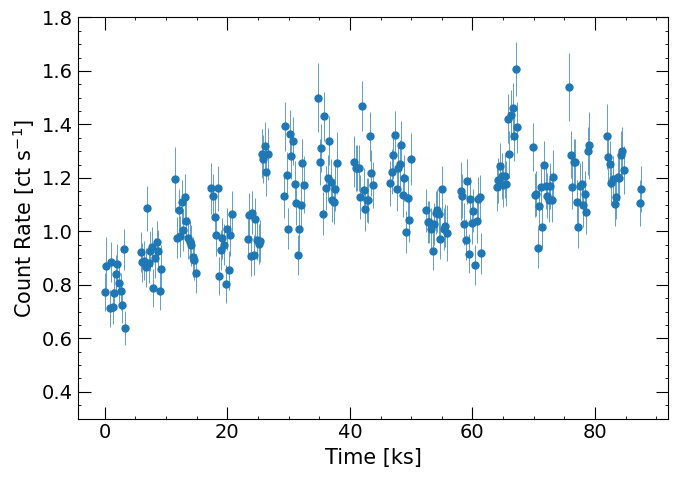

In [17]:
plt.figure(figsize=(7, 5))

# Configure the axis ticks
plt.minorticks_on()
plt.tick_params(which="both", direction="in", right=True)

# Plot the data
plt.errorbar(time / 1e3, rate, rerr, fmt="o", lw=0.5)

# Set limits on the y-axis, for better interpretability
plt.ylim([0.3, 1.8])

# Create axis labels
plt.xlabel("Time [ks]", fontsize=15)
plt.ylabel(r"Count Rate [ct s$^{-1}$]", fontsize=15)

plt.tight_layout()
plt.show()

## 5. Extracting the spectrum
In a similar way, we use `nuproducts` to extract the source and background spectra:

In [18]:
# Ensure that a directory to store our new spectra exists
os.makedirs(os.path.join(OUT_PATH, f"{OBS_ID}", "spectra"), exist_ok=True)

sp_params = {
    "indir": "event_cl",
    "outdir": "spectra",
    "instrument": "FPMA",
    "steminputs": f"nu{OBS_ID}",
    "imagefile": "NONE",
    "lcfile": "NONE",
    "bkglcfile": "NONE",
    "bkgextract": "yes",
    "srcregionfile": os.path.abspath("src.reg"),
    "bkgregionfile": os.path.abspath("bgd.reg"),
    "phafile": "DEFAULT",
    "bkgphafile": "DEFAULT",
    "runbackscale": "yes",
    "runmkarf": "yes",
    "runmkrmf": "yes",
}

# Use the chdir context manager to move us into the output directory for the
#  light curve extraction task.
with contextlib.chdir(os.path.join(OUT_PATH, f"{OBS_ID}")):
    sp_out = hsp.nuproducts(
        sp_params, noprompt=True, verbose=20, logfile="nuproducts_spec.log"
    )

In [19]:
# A return code of `0`, indicates that the task ran successfully!
assert sp_out.returncode == 0

Next, we want to group the spectrum so we can model it in XSPEC using $\chi^2$ minimization.

For that, we use `ftgrouppha`
(see the [detailed documentation here](https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/help/ftgrouppha.html))
to combine spectral channels using the 'optimal binning method' until a minimum
signal-to-noise ratio of 6 is reached:

In [20]:
# Hop into the spectra directory for the duration
with contextlib.chdir(os.path.join(OUT_PATH, f"{OBS_ID}", "spectra")):
    grp_out = hsp.ftgrouppha(
        infile=f"nu{OBS_ID}A01_sr.pha",
        outfile=f"nu{OBS_ID}A01_grpd_sr.pha",
        grouptype="optsnmin",
        groupscale=6,
        respfile=f"nu{OBS_ID}A01_sr.rmf",
        clobber=True,
    )

# Check if the task ran successfully
assert grp_out.returncode == 0

## 6. Using PyXspec to load, fit, and plot a spectrum
Our next step is to load the spectrum into PyXspec (a Python-based interface to the
ubiquitous X-ray spectral fitting tool, XSPEC). Alternatively, you could switch to
your terminal and use `xspec` in the command line.

This is going to let us fit a model to the spectrum we've created for our AGN, which
will allow us to parameterize how the emission changes across NuSTAR's considerable
energy range.

### Loading the spectrum

We'll start by navigating to the directory where we generate the spectrum product, just
to make the path we supply to PyXspec a little nicer to look at.

When it comes to using PyXspec to load the spectrum, we first run the `AllData.clear()`
method - this will ensure that any existing loaded data are removed. We _know_ there
are no existing data loaded in this tutorial, but it is still good
practice (particularly in notebook environments where variables persist across cells).

Also note that we 'ignore' any spectral data points below 3 keV and above 79 keV - this
represents NuSTAR's effective energy range, and any data points outside are likely to
be dubious.

In [21]:
# To be safe, we clear any existing data loaded into PyXspec. This will only
#  matter if you started re-running cells without re-running the whole notebook
xs.AllData.clear()

# Move into the spectra directory and load the spectrum
with contextlib.chdir(os.path.join(OUT_PATH, f"{OBS_ID}", "spectra")):
    spec = xs.Spectrum(f"nu{OBS_ID}A01_grpd_sr.pha")
    spec.ignore("0.0-3.0, 79.-**")

Creating a $HOME/.xspec directory for you

1 spectrum  in use
 
Spectral Data File: nu60001110002A01_grpd_sr.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.232e-01 +/- 4.269e-03 (86.6 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-202
  Telescope: NuSTAR Instrument: FPMA  Channel Type: PI
  Exposure Time: 4.92e+04 sec
 Using fit statistic: chi
 Using Background File                nu60001110002A01_bk.pha
  Background Exposure Time: 4.92e+04 sec
 Using Response (RMF) File            nu60001110002A01_sr.rmf for Source 1
 Using Auxiliary Response (ARF) File  nu60001110002A01_sr.arf

     8 channels (1-8) ignored in spectrum #     1
    48 channels (155-202) ignored in spectrum #     1


### Fitting a spectral model

To demonstrate how to fit a spectral model, we perform an extremely simple fit to a powerlaw.

In many situations you may want to set start values for the parameters of the
model, and you should visit the [PyXspec documentation](https://heasarc.gsfc.nasa.gov/docs/software/xspec/python/html/index.html)
for more information.

```{seealso}
A full list of XSPEC models can be [found here](https://heasarc.gsfc.nasa.gov/docs/software/xspec/manual/node128.html).
```

In [22]:
model = xs.Model("powerlaw")
xs.Fit.perform()


Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              1.751191e+10     using 146 bins.

Test statistic : Chi-Squared              1.751191e+10     using 146 bins.
 Null hypothesis probability of 0.000000e+00 with 144 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl    1:PhoIndex        2:norm
5456.61      3374.25      -2       1.55966    0.00280920
3339.23      1.25573e+06  -3       1.93892    0.00694195
544.324      461812       -4       1.73805    0.00745046
266.24       198095       -5       1.79828    0.00773776
265.643      6522.54      -6       1.80416    0.00780238
265.643      41.2509 

   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              1.751191e+10     using 146 bins.

Test statistic : Chi-Squared              1.751191e+10     using 146 bins.
 Null hypothesis probability of 0.000000e+00 with 144 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl    1:PhoIndex        2:norm
5456.61      3374.25      -2       1.55966    0.00280920
3339.23      1.25573e+06  -3       1.93892    0.00694195
544.324      461812       -4       1.73805    0.00745046
266.24       198095       -5       1.79828    0.00773776
265.643      6522.54      -6       1.80416    0.00780238
265.643      41.2509      -7       1.80417    0.00780267
 Variances and Principal Axes
                 1        2  
 2.0386E-

### Plotting the fitted spectrum

The PyXspec module provides a 'Plot' object, from which we can extract all the information required to plot the spectrum.

We could generate visualization of the spectrum using just that 'Plot' object, but instead we demonstrate how to plot the spectrum using the matplotlib module.

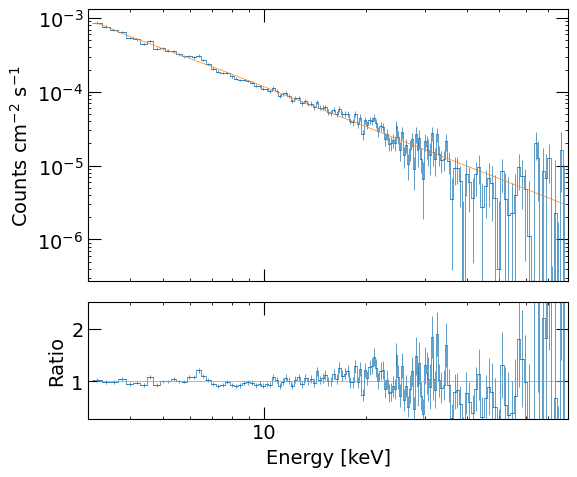

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(6, 5), sharex=True, height_ratios=(0.7, 0.3))
fig.subplots_adjust(hspace=0)

# Plot the spectral data
xs.Plot.area = True
xs.Plot.xAxis = "keV"
xs.Plot("data")
xval, xerr, yval, yerr = xs.Plot.x(), xs.Plot.xErr(), xs.Plot.y(), xs.Plot.yErr()
axs[0].step(xval, yval, color="C0", where="mid", lw=0.5)
axs[0].errorbar(xval, yval, yerr, fmt=".", ms=0, xerr=xerr, lw=0.5)

# Plot the fitted model as well
axs[0].loglog(xval, xs.Plot.model(), lw=0.5)

# Set up axis limits and labels
axs[0].set_xlim(3, 80)
axs[0].set_ylabel("Counts cm$^{-2}$ s$^{-1}$")

# plot the ratio
xs.Plot("ratio")
xval, xerr, yval, yerr = xs.Plot.x(), xs.Plot.xErr(), xs.Plot.y(), xs.Plot.yErr()
axs[1].step(xval, yval, color="C0", where="mid", lw=0.5)
axs[1].errorbar(xval, yval, yerr, fmt=".", ms=0, xerr=xerr, lw=0.5)
axs[1].plot([xval[0], xval[-1]], [1, 1], "-", lw=0.5)
axs[1].set_ylim(0.3, 2.5)

# Set up axis limits and labels
axs[1].set_xlabel("Energy [keV]")
axs[1].set_ylabel("Ratio")
# Also, format the x-axis tick labels to be shown as integers rather than powers
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

plt.tight_layout()
plt.show()

## About this Notebook

Author: Abdu Zoghbi, HEASARC Staff Scientist

Author: David J Turner, HEASARC Staff Scientist

Updated On: 2026-02-03

### Additional Resources

Support: [NuSTAR GOF Helpdesk](https://heasarc.gsfc.nasa.gov/cgi-bin/Feedback?selected=nustar)

[`nuproducts` documentation](https://heasarc.gsfc.nasa.gov/lheasoft/ftools/caldb/help/nuproducts.html)

[`ftgrouppha` documentation](https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/help/ftgrouppha.html)

[PyXspec documentation](https://heasarc.gsfc.nasa.gov/docs/software/xspec/python/html/index.html)

[XSPEC Model Components](https://heasarc.gsfc.nasa.gov/docs/software/xspec/manual/node128.html)

### Acknowledgements

### References